In [34]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import numpy as np

import glob

from openff.toolkit.topology import Molecule
from rdkit.Chem import TorsionFingerprints

IPythonConsole.ipython_useSVG=True 
IPythonConsole.molSize = 500, 500

import glob
import numpy as np
from MDAnalysis.analysis import rms

In [35]:
def read_first_confs(i=1):
    molname = f"conformers/mol{i:04d}"
    rdname = f"{molname}*_rd.npy"
    oename = f"{molname}*_oe.npy"
    
    rdconfs = []
    oeconfs = []
    
    for file in sorted(glob.glob(rdname)):
        rdconf = np.load(file)
        rdconfs.append(rdconf[0])
        
    for file in sorted(glob.glob(oename)):
        oeconf = np.load(file)
        oeconfs.append(oeconf[0])
        
    toolkits = ["RDKit"] * len(rdconfs) + ["OpenEye"] * len(oeconfs)
        
    confs = np.concatenate([rdconfs, oeconfs])
    return confs, toolkits

In [36]:

def read_charges(i=1):
    files = glob.glob(f"charges/mol{i:04d}_*am1.npy")
    if not len(files) == 4:
        return {}

    dct = {"oe": [], "at": []}

    for file in sorted(files, reverse=True):
        conformers, toolkit = file.split("_")[1:-1]
        charges = np.load(file)
        dct[toolkit].extend(charges)

    dct = {k: np.array(v) for k, v in dct.items()}
    return dct


In [37]:
def get_rmsds(dct):
    rmsds = {}

    for k, charges in dct.items():
        krms = np.zeros((len(charges), len(charges)))
        for i, iconf in enumerate(charges):
            for j, jconf in enumerate(charges[i + 1:], i + 1):
                r = np.mean(((iconf - jconf) ** 2).sum()) ** 0.5
                krms[i, j] = krms[j, i] = r
        rmsds[k] = krms
    return rmsds

def get_maxes(dct):
    rmsds = {}

    for k, charges in dct.items():
        krms = np.zeros((len(charges), len(charges)))
        for i, iconf in enumerate(charges):
            for j, jconf in enumerate(charges[i + 1:], i + 1):
                r = np.abs(iconf - jconf).max()
                krms[i, j] = krms[j, i] = r
        rmsds[k] = krms
    return rmsds

In [38]:
rmsds

NameError: name 'rmsds' is not defined

In [39]:
dct["oe"].shape

NameError: name 'dct' is not defined

In [40]:
rmsds["oe"].shape

NameError: name 'rmsds' is not defined

In [41]:
def rmsd_first_confs(i=1):
    confs, toolkits = read_first_confs(i=i)
    
    rmsds = np.zeros((len(confs), len(confs)))
    for i, iconf in enumerate(confs):
        for j, jconf in enumerate(confs[i + 1:], i + 1):
            rmsds[i, j] = rmsds[j, i] = rms.rmsd(iconf, jconf, superposition=True)
    return rmsds, toolkits

In [42]:
def plot_oe_vs_at_max(i=1, linecolor="white", linewidths=0.1,):

    from matplotlib import pyplot as plt
    import numpy as np
    import seaborn as sns

    _, toolkits = rmsd_first_confs(i)
    dct = read_charges(i)
    if not dct:
        raise ValueError()
    rmsds = get_maxes(dct)

    values = np.zeros_like(rmsds["oe"])
    iu = np.triu_indices(rmsds["oe"].shape[0], k=1)
    il = np.tril_indices(rmsds["oe"].shape[0], k=-1)
    values[il] = rmsds["at"][il]
    values[iu] = rmsds["oe"][iu]

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    mask = np.ones_like(rmsds["oe"], dtype=bool)
    mask[iu] = False
    mask[np.diag_indices(mask.shape[1])] = False

    sns.heatmap(values, ax=ax, cmap="gist_heat", cbar=True,
                linecolor=linecolor, linewidths=linewidths,
                mask=mask, square=True, xticklabels=[],
                yticklabels=[],
                cbar_kws={"label": "Max charge difference (OpenEye)",
                          "location": "right"},
               )
    mask = ~mask
    sns.heatmap(values, ax=ax, cmap="bone", cbar=True,
                linecolor=linecolor, linewidths=linewidths,
                mask=mask, square=True, xticklabels=[],
                yticklabels=[],
                cbar_kws={"label": "Max charge difference (AmberTools)",
                          "location": "left",
                         },
               )

    # lines
    sns.despine(offset=8, ax=ax);

    XJ = len(rmsds["oe"])
    xi, xj = np.where(np.array(toolkits) == "RDKit")[0][[0, -1]]
    xj += 1
    tickrange = [int((xj - xi)/2), xj, int(xj + (XJ - xj)/2)]
    ticks = ["RDKit", "", "OpenEye"]
    ax.set_yticks(tickrange)
    ax.set_xticks(tickrange)
    ax.set_yticklabels(ticks, fontsize=12, va="center", rotation=90)
    ax.set_xticklabels(ticks, fontsize=12, va="top", ha="center")
    ax.vlines(x=xj, ymin=0, ymax=XJ, lw=3, color="white")
    ax.hlines(y=xj, xmin=0, xmax=XJ, lw=3, color="white")


    plt.tight_layout()
    plt.savefig(f"images/first_conformer/mol{i:04d}_charges_first_conf_max.png", dpi=300)
    return fig

In [43]:
def plot_oe_vs_at_rmsd(i=1, linecolor="white", linewidths=0.1,):

    from matplotlib import pyplot as plt
    import numpy as np
    import seaborn as sns

    _, toolkits = rmsd_first_confs(i)
    dct = read_charges(i)
    if not dct:
        raise ValueError()
    rmsds = get_rmsds(dct)

    values = np.zeros_like(rmsds["oe"])
    iu = np.triu_indices(rmsds["oe"].shape[0], k=1)
    il = np.tril_indices(rmsds["oe"].shape[0], k=-1)
    values[il] = rmsds["at"][il]
    values[iu] = rmsds["oe"][iu]

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    mask = np.ones_like(rmsds["oe"], dtype=bool)
    mask[iu] = False
    mask[np.diag_indices(mask.shape[1])] = False

    sns.heatmap(values, ax=ax, cmap="gist_heat", cbar=True,
                linecolor=linecolor, linewidths=linewidths,
                mask=mask, square=True, xticklabels=[],
                yticklabels=[],
                cbar_kws={"label": "Charge RMSD (OpenEye)",
                          "location": "right"},
               )
    mask = ~mask
    sns.heatmap(values, ax=ax, cmap="bone", cbar=True,
                linecolor=linecolor, linewidths=linewidths,
                mask=mask, square=True, xticklabels=[],
                yticklabels=[],
                cbar_kws={"label": "Charge RMSD (AmberTools)",
                          "location": "left",
                         },
               )

    # lines
    sns.despine(offset=8, ax=ax);

    XJ = len(rmsds["oe"])
    xi, xj = np.where(np.array(toolkits) == "RDKit")[0][[0, -1]]
    xj += 1
    tickrange = [int((xj - xi)/2), xj, int(xj + (XJ - xj)/2)]
    ticks = ["RDKit", "", "OpenEye"]
    ax.set_yticks(tickrange)
    ax.set_xticks(tickrange)
    ax.set_yticklabels(ticks, fontsize=12, va="center", rotation=90)
    ax.set_xticklabels(ticks, fontsize=12, va="top", ha="center")
    ax.vlines(x=xj, ymin=0, ymax=XJ, lw=3, color="white")
    ax.hlines(y=xj, xmin=0, xmax=XJ, lw=3, color="white")


    plt.tight_layout()
    plt.savefig(f"images/first_conformer/mol{i:04d}_charges_first_conf_rmsd.png", dpi=300)
    return fig

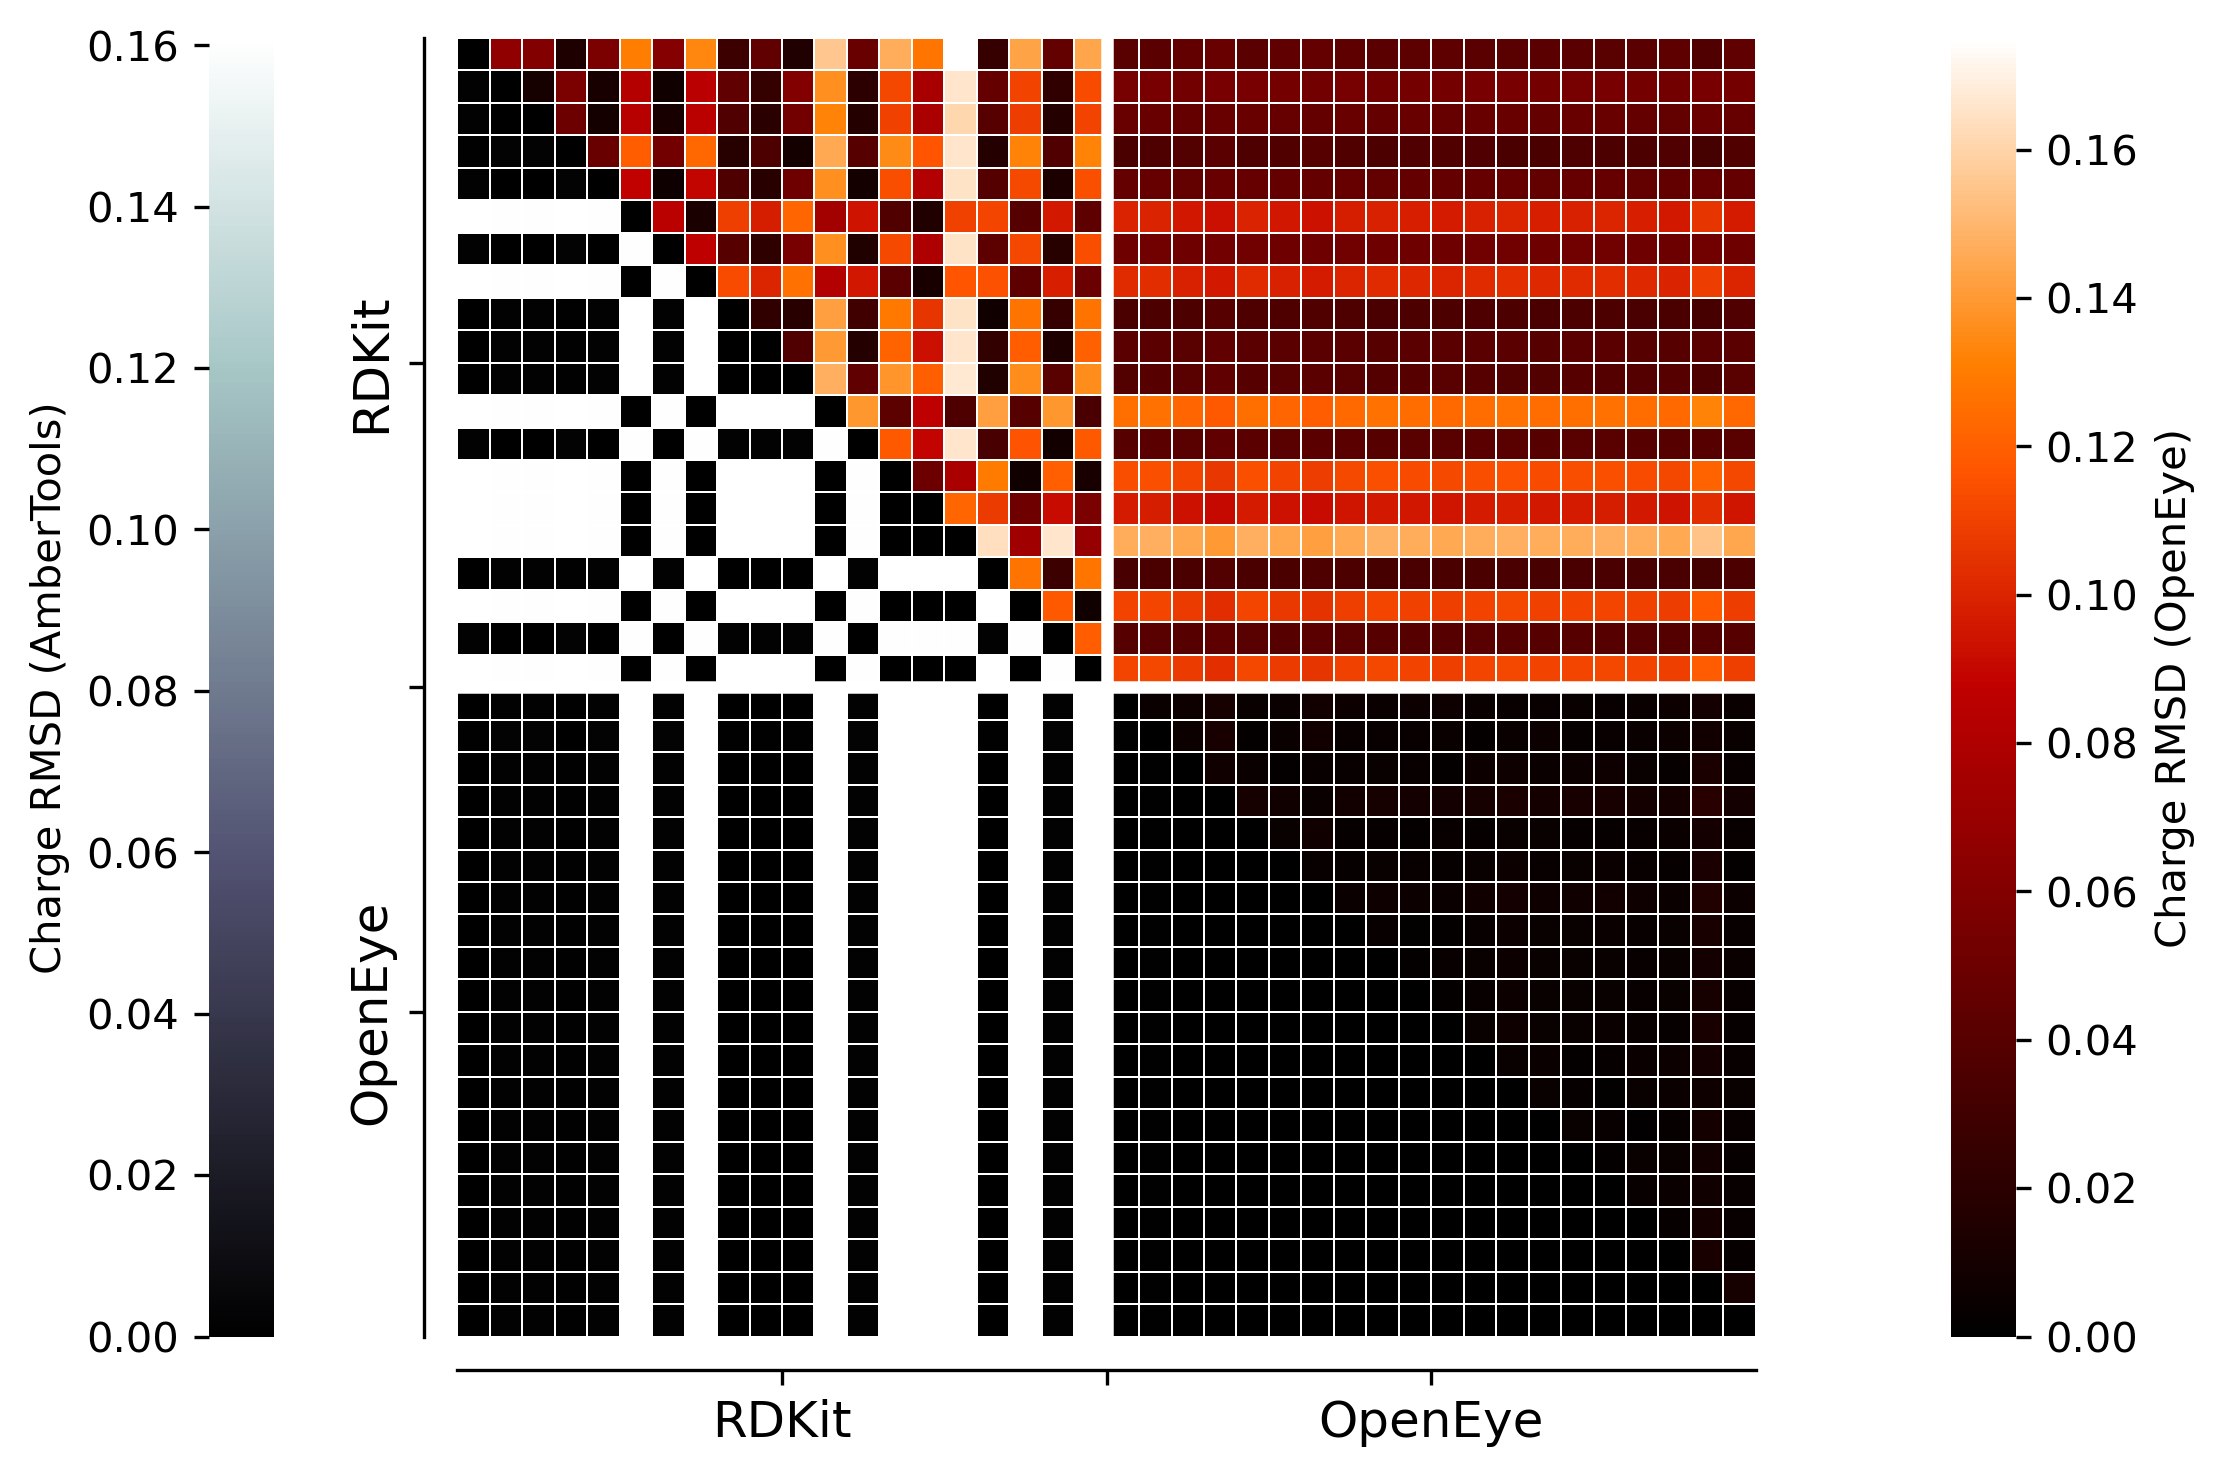

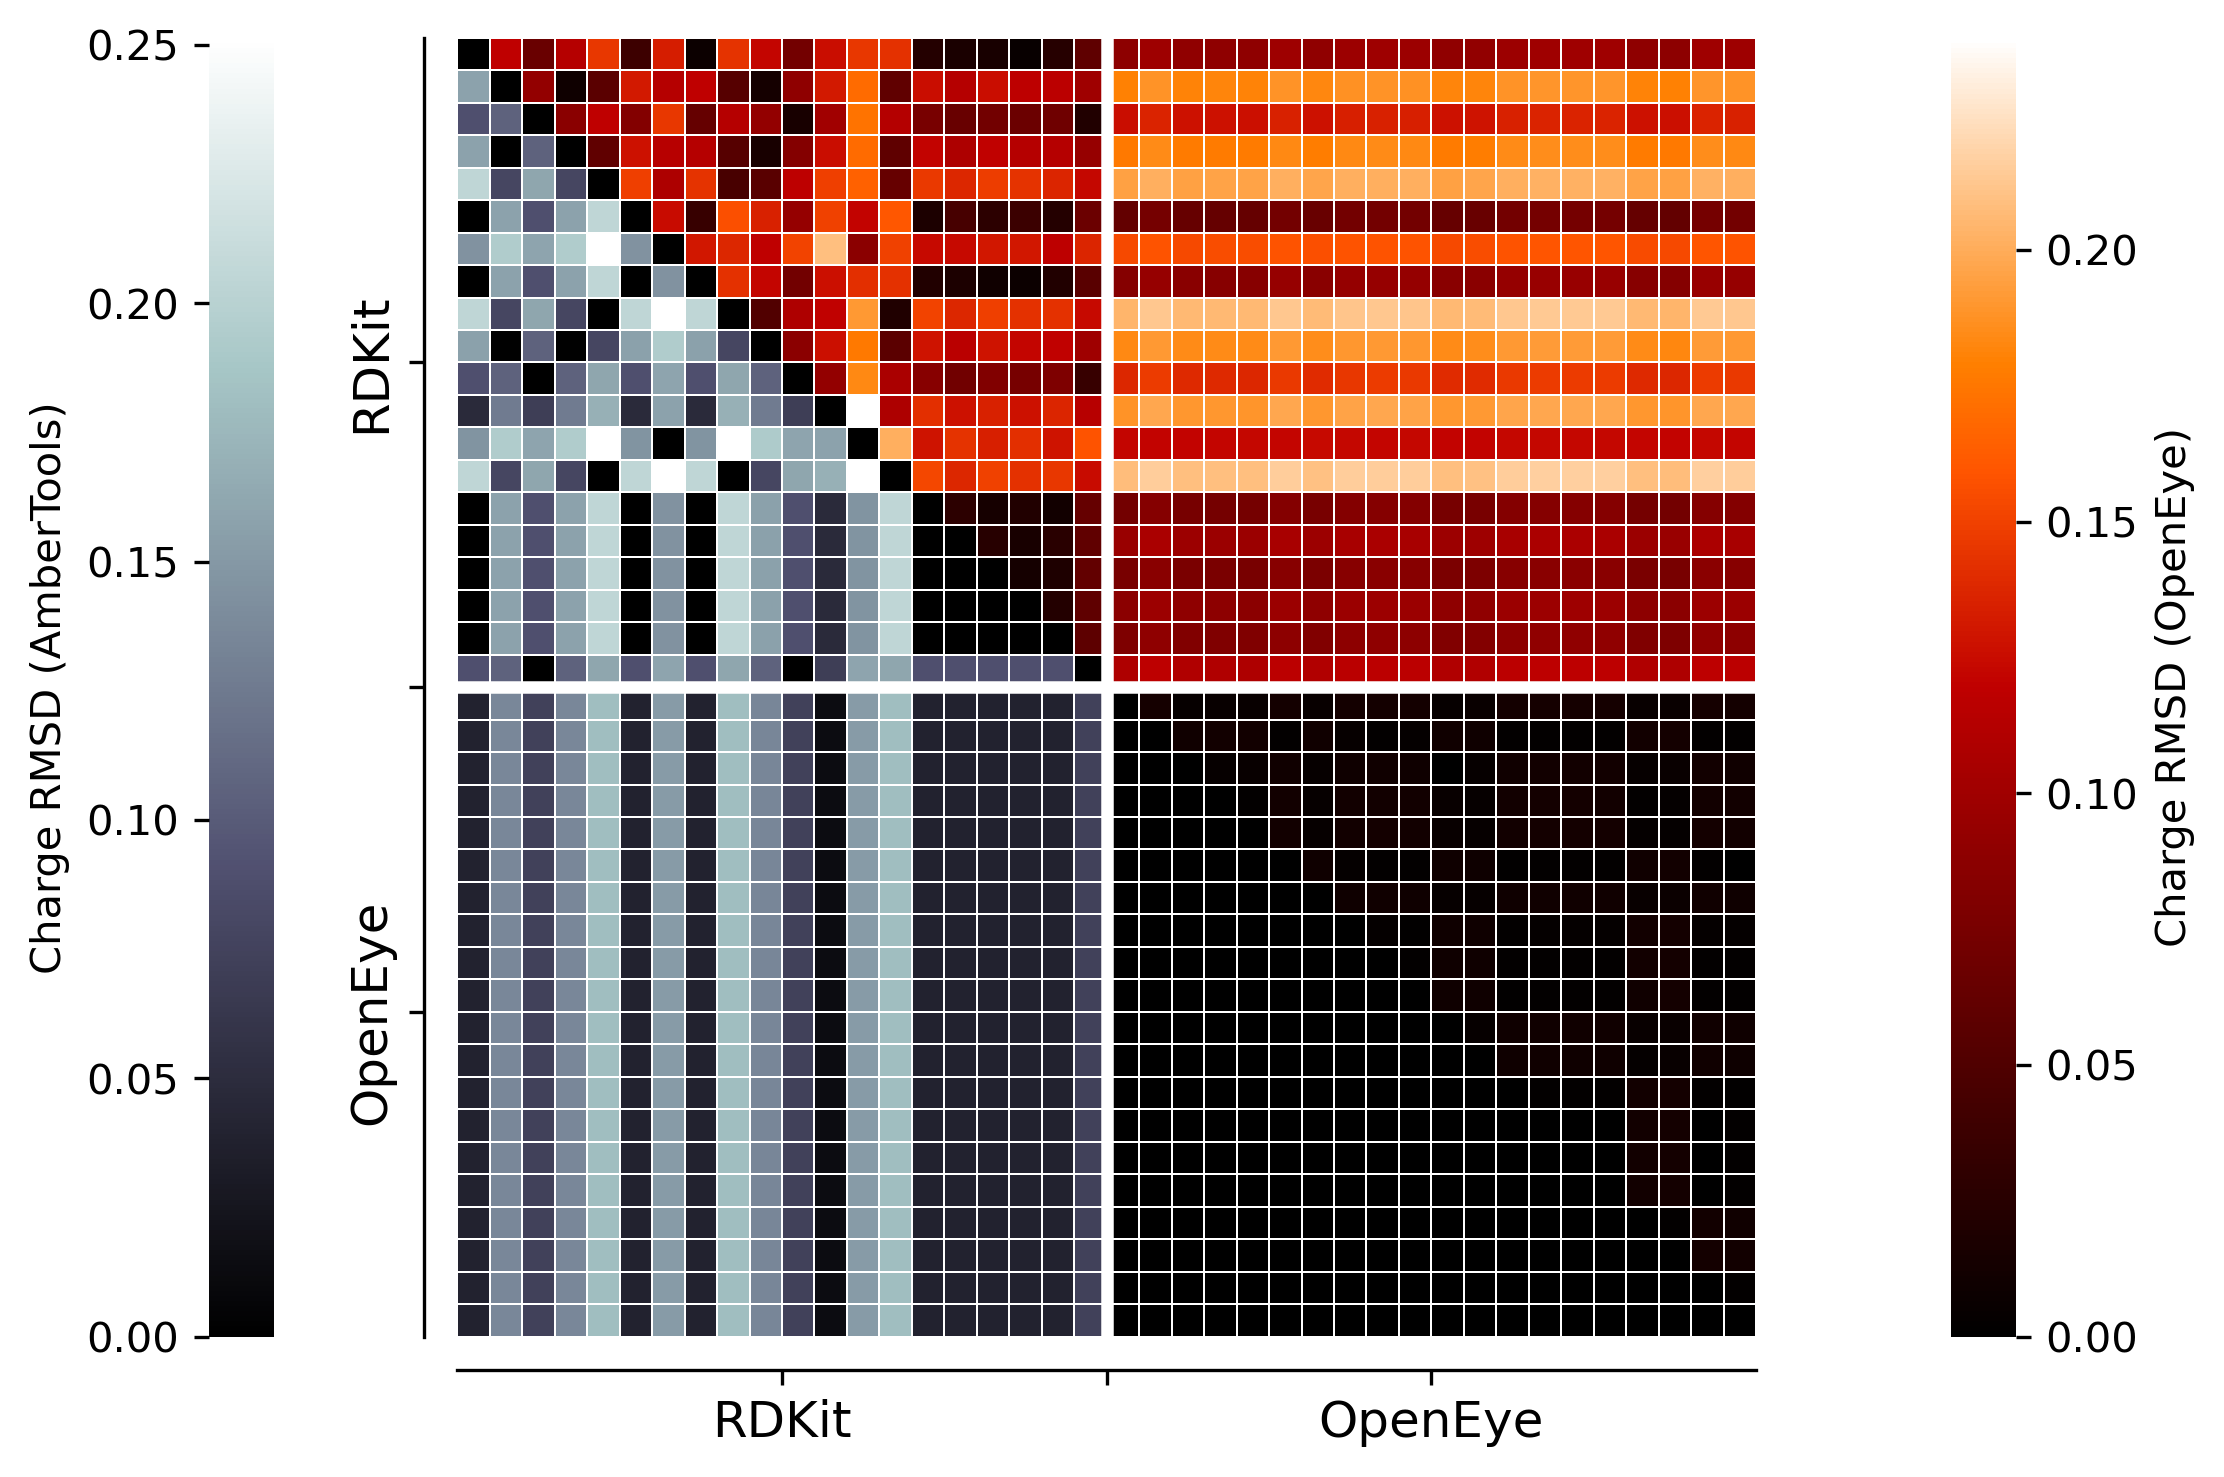

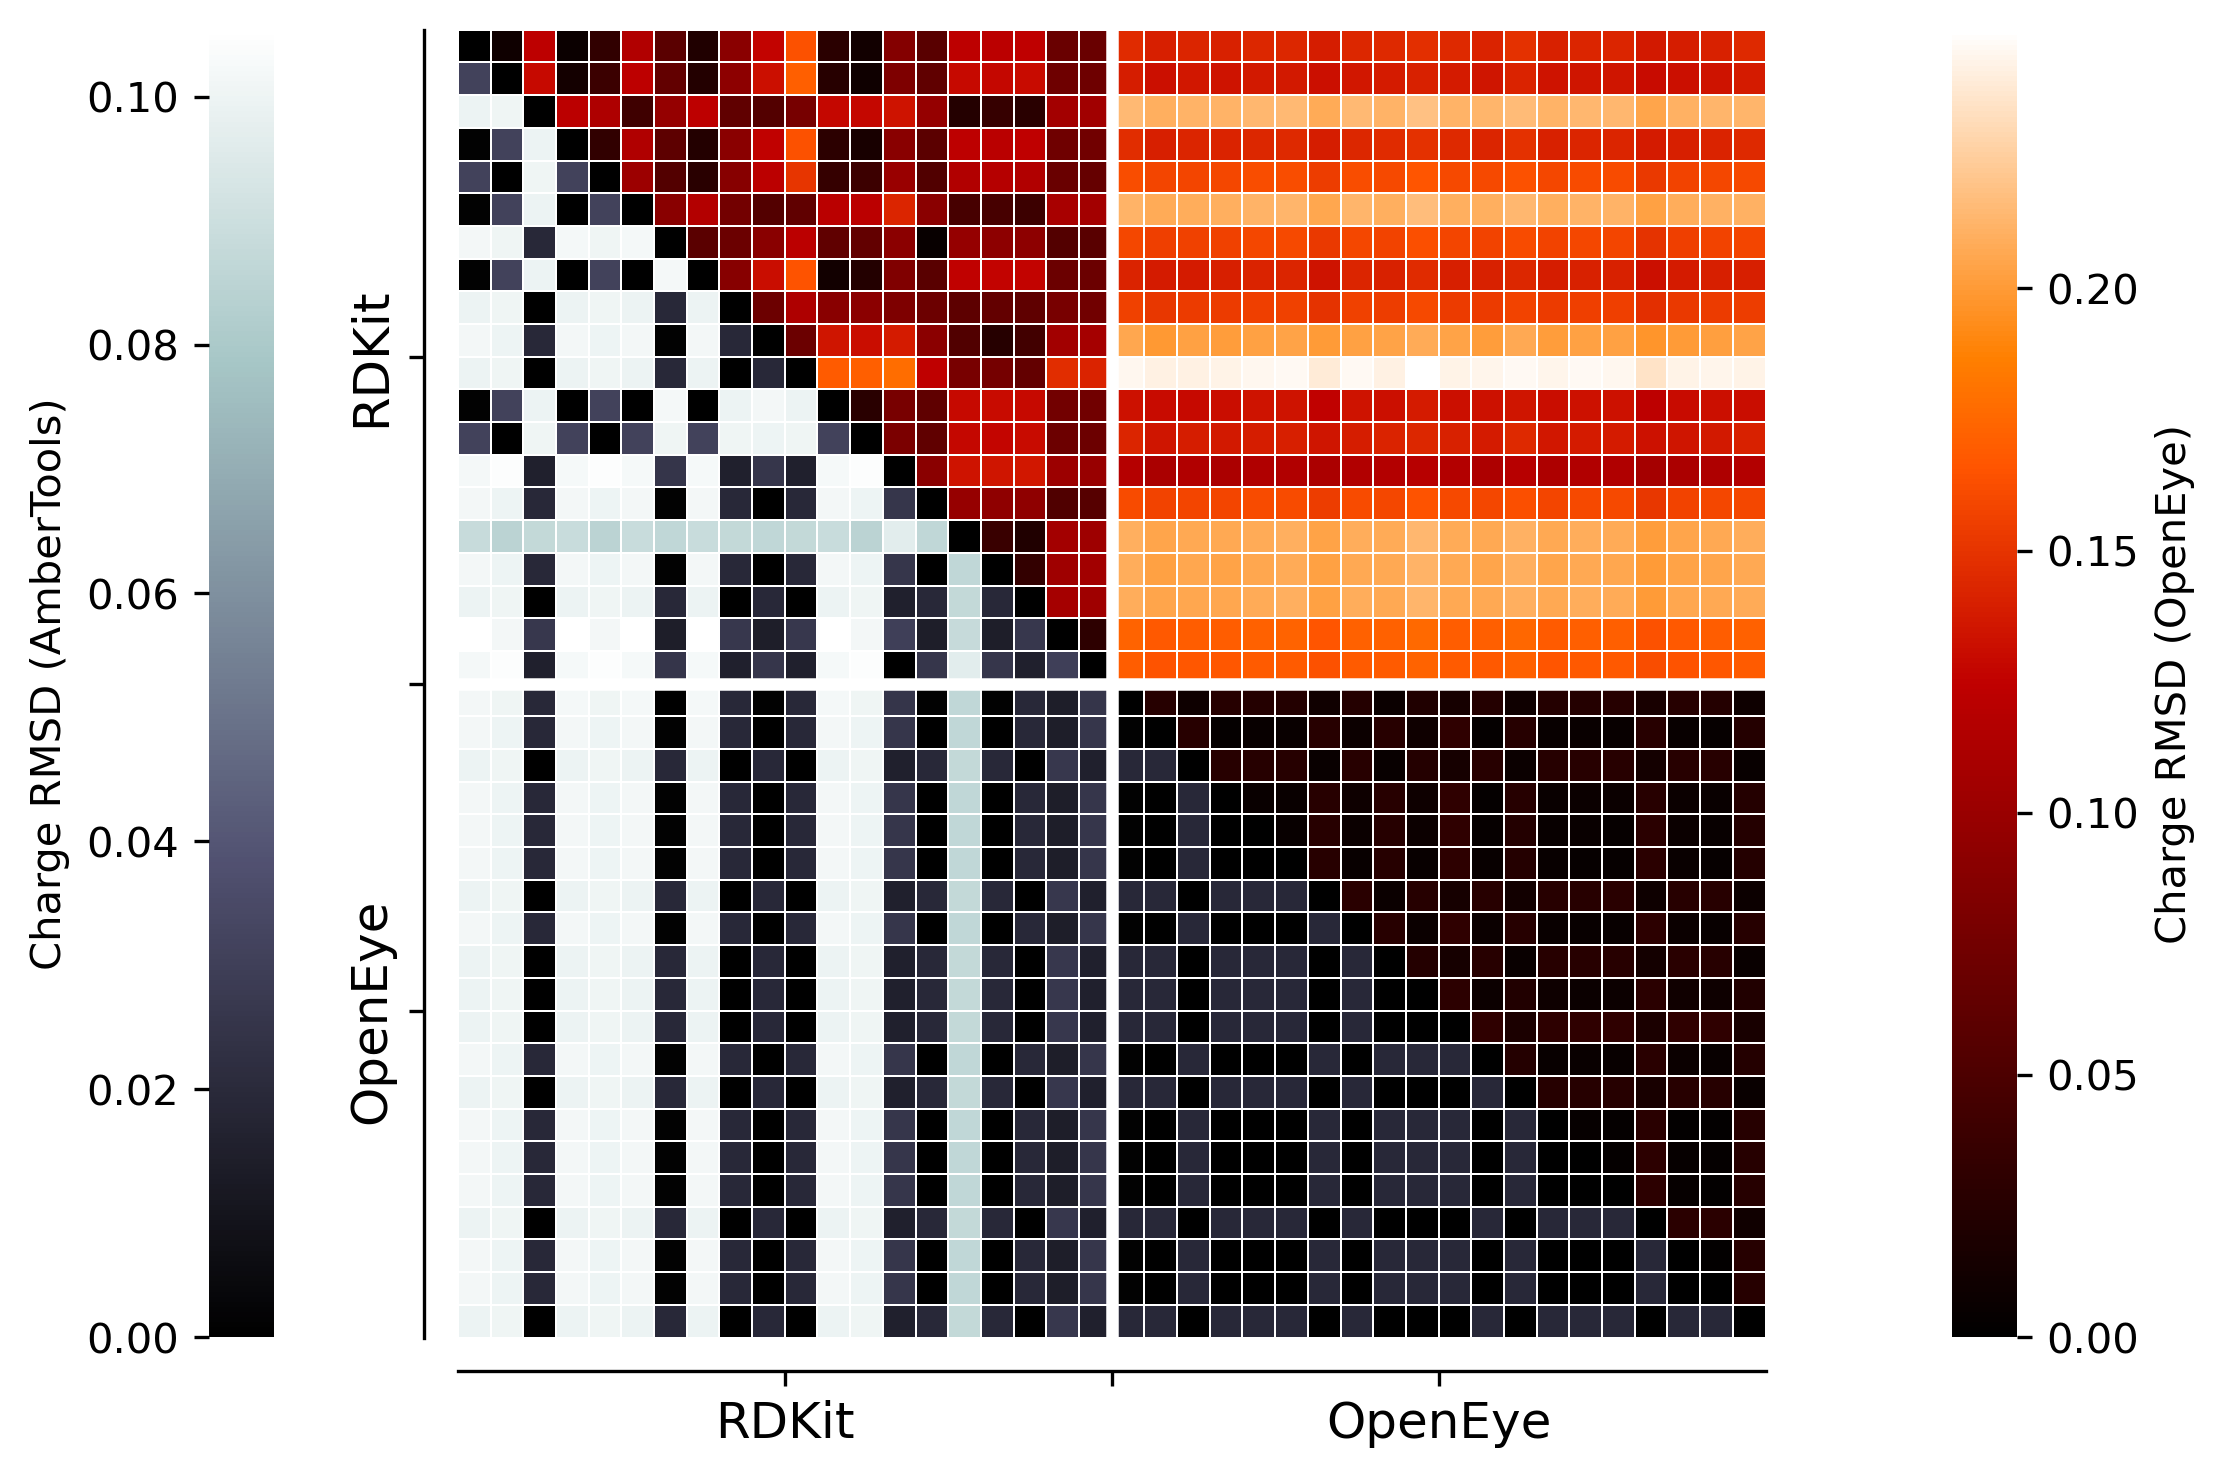

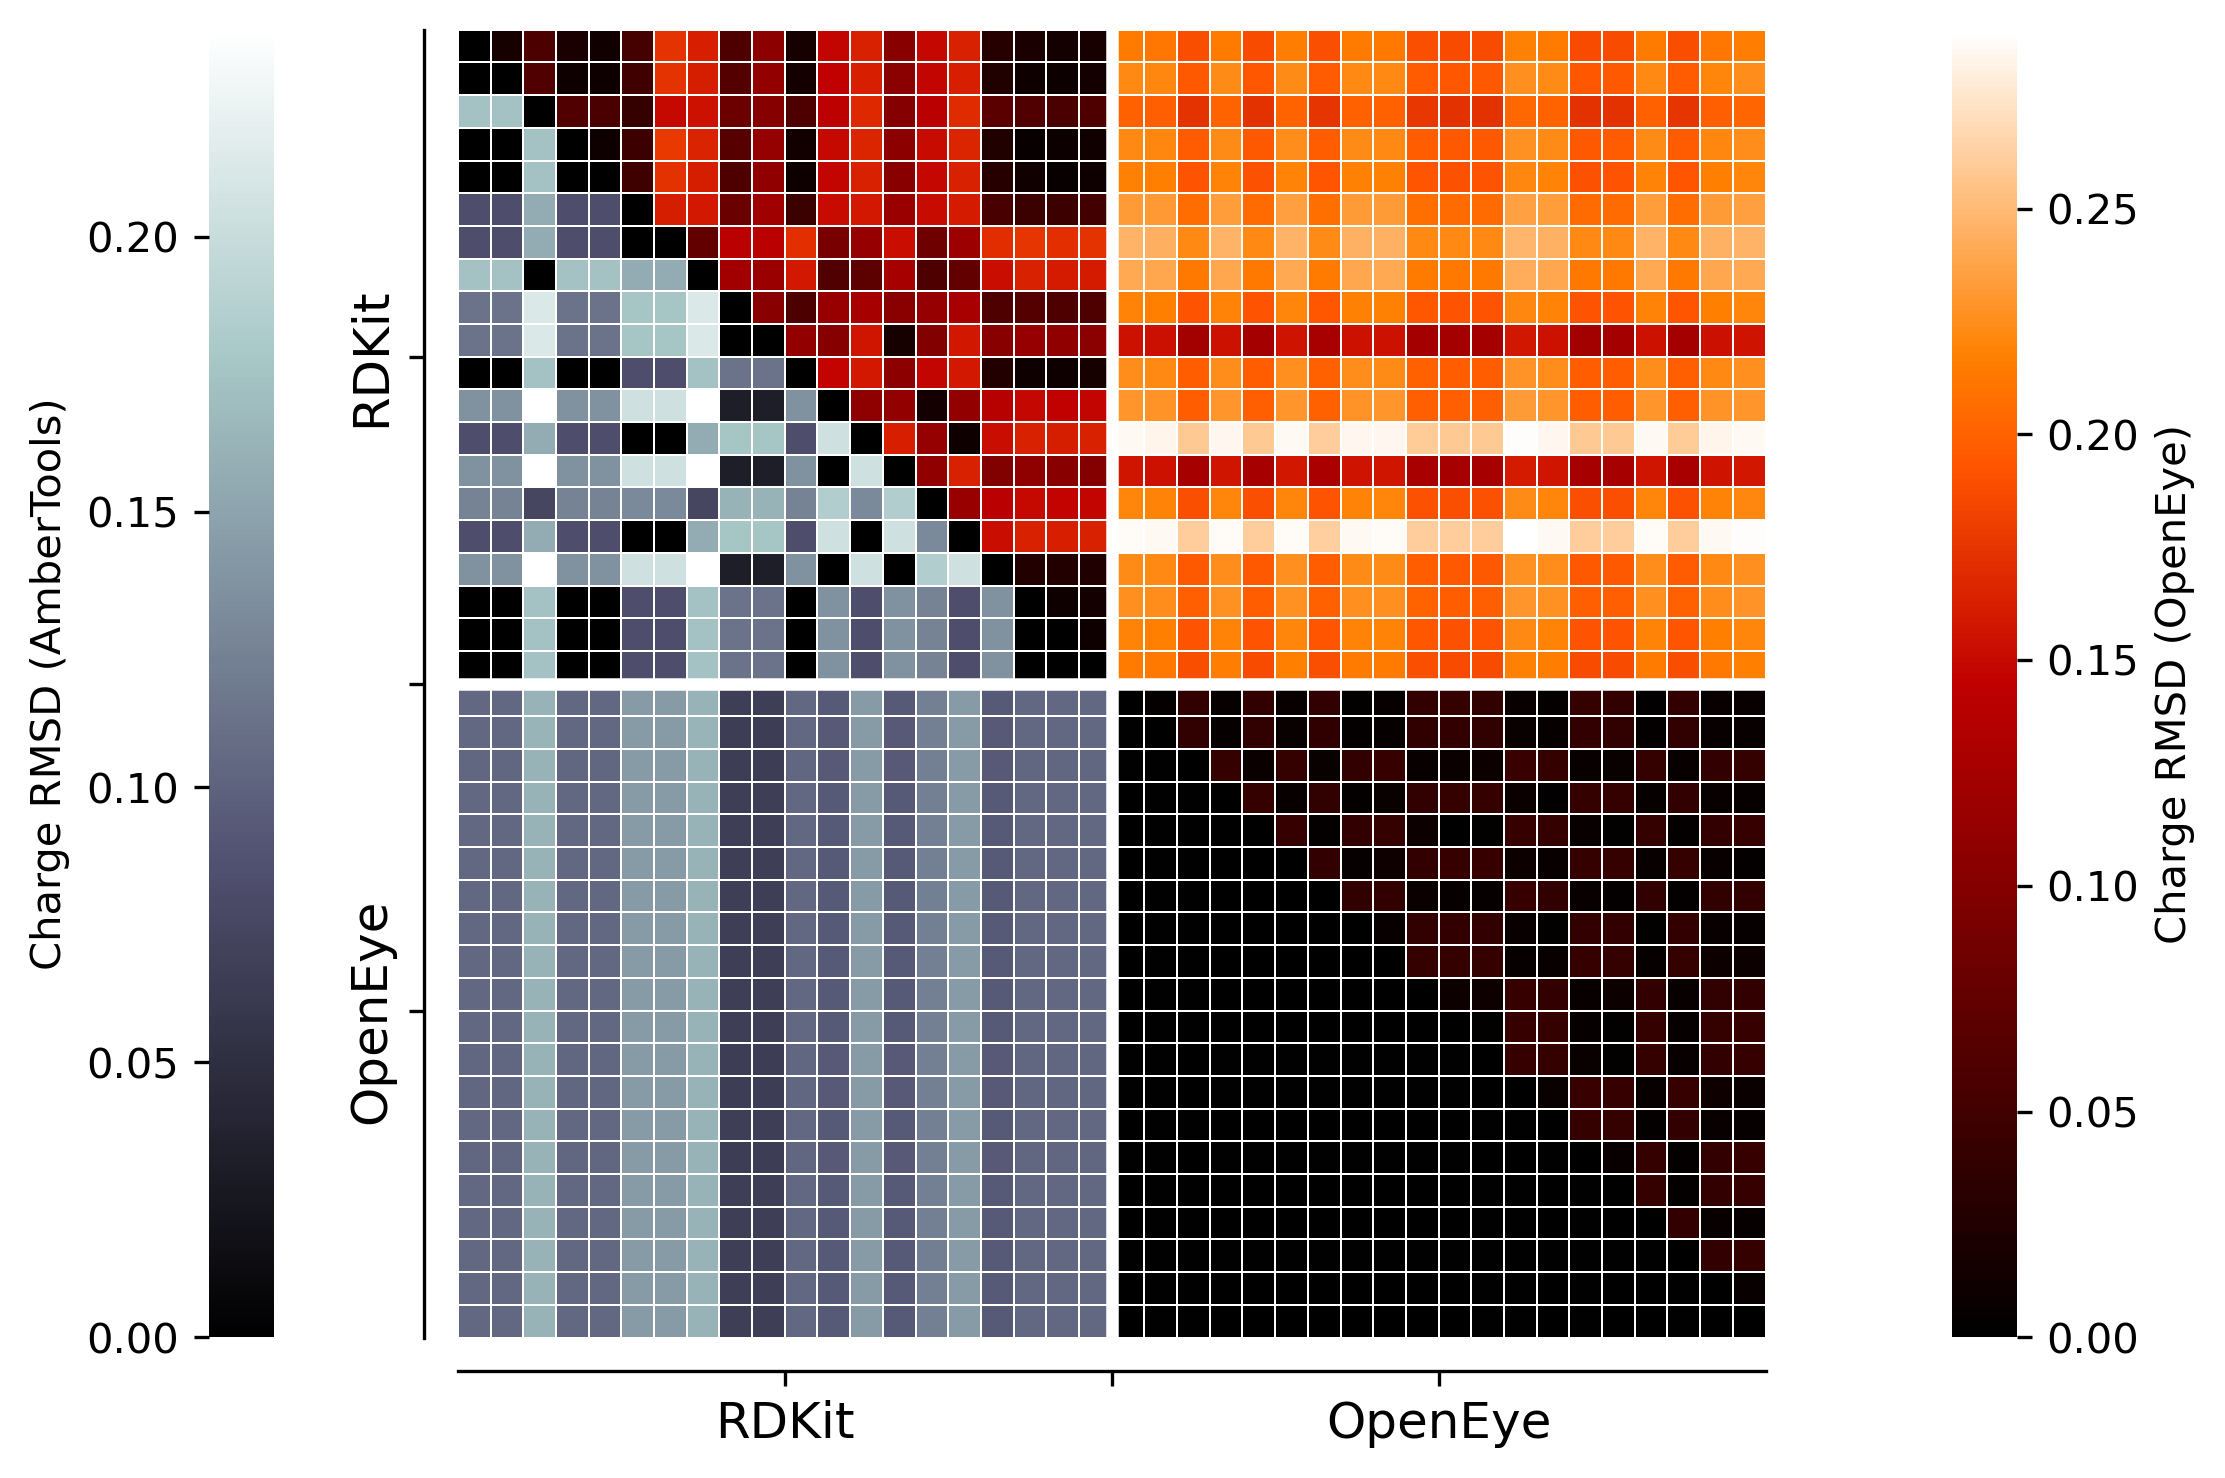

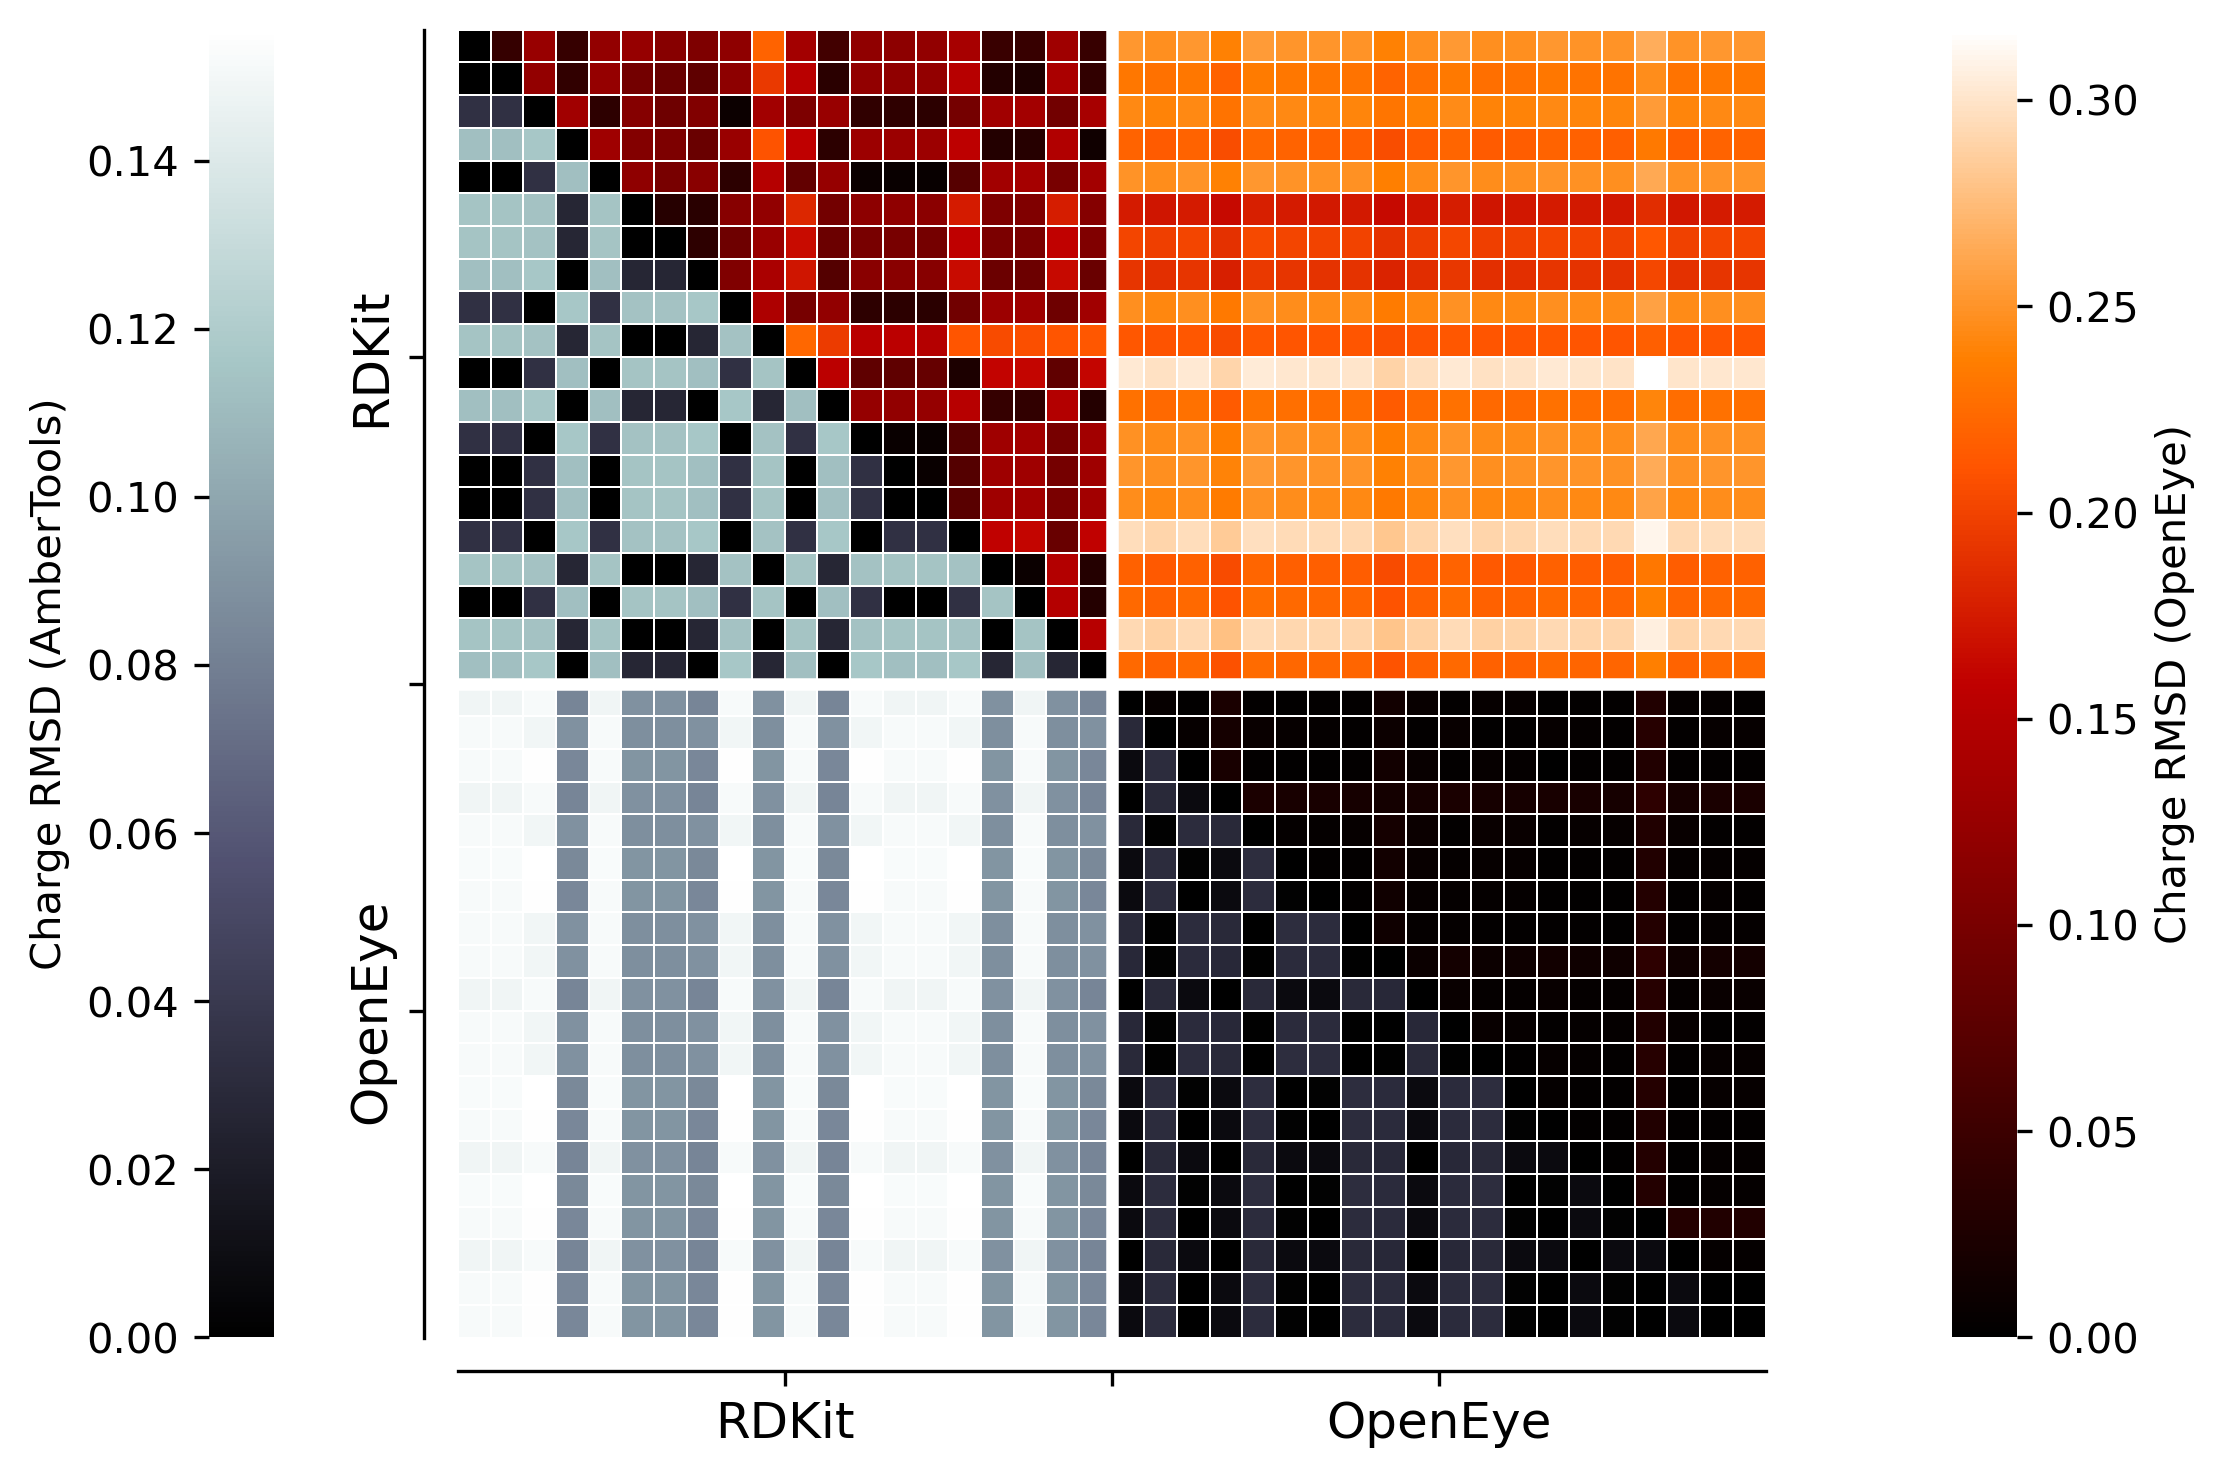

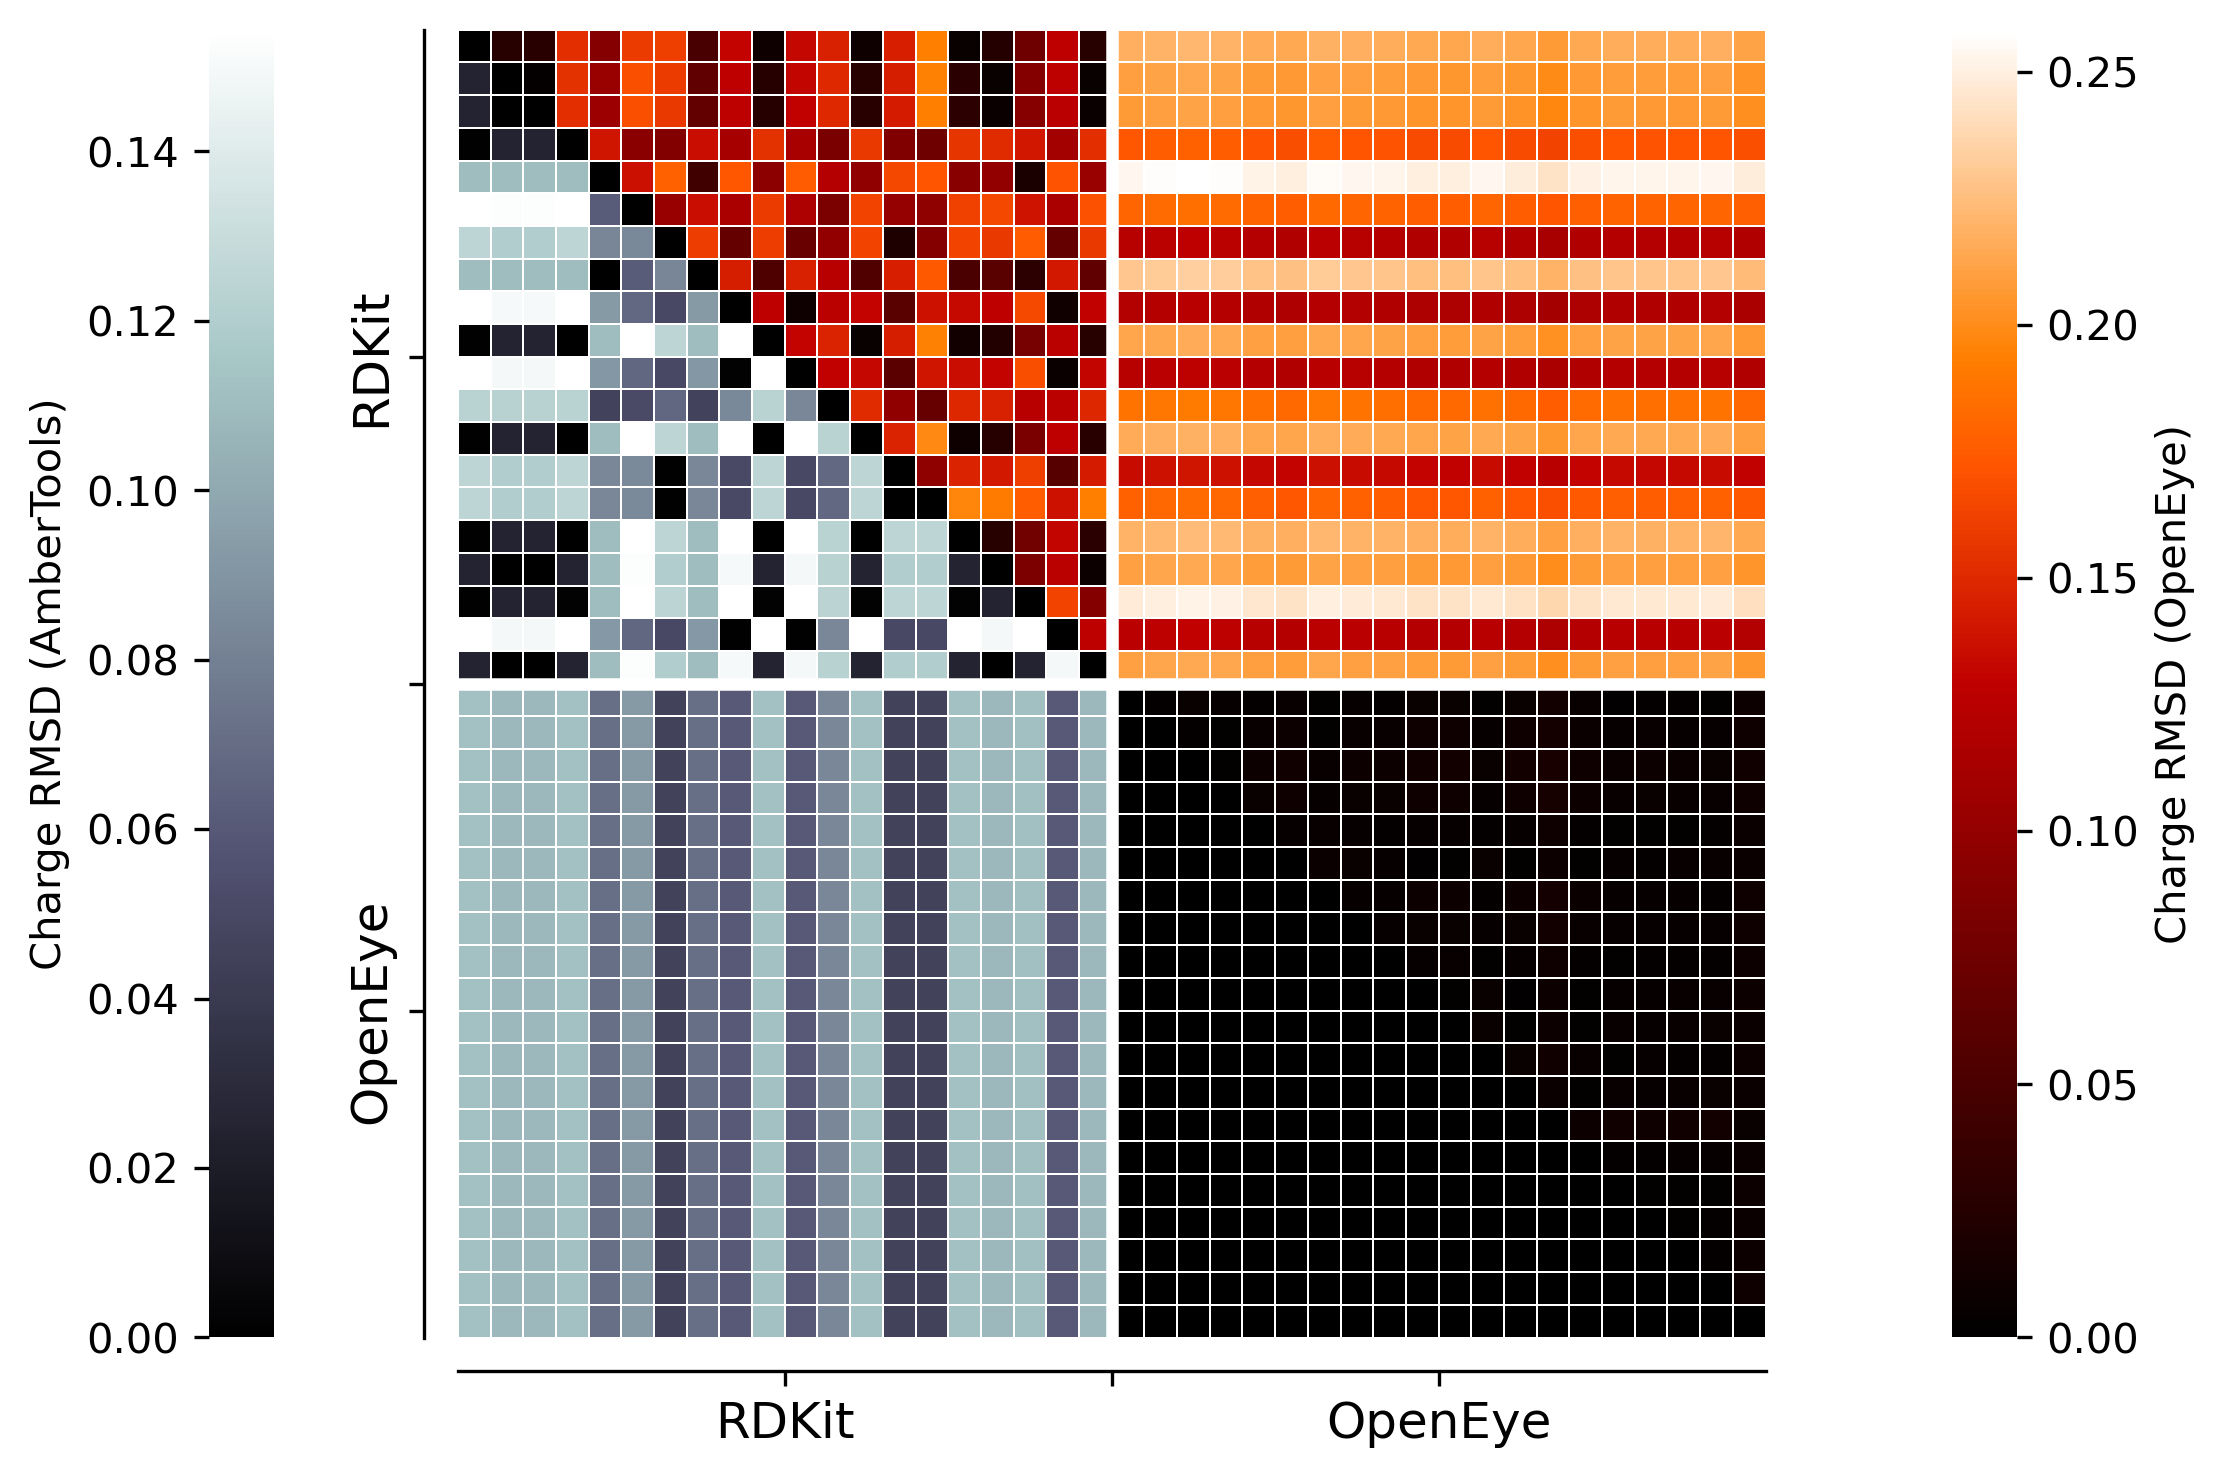

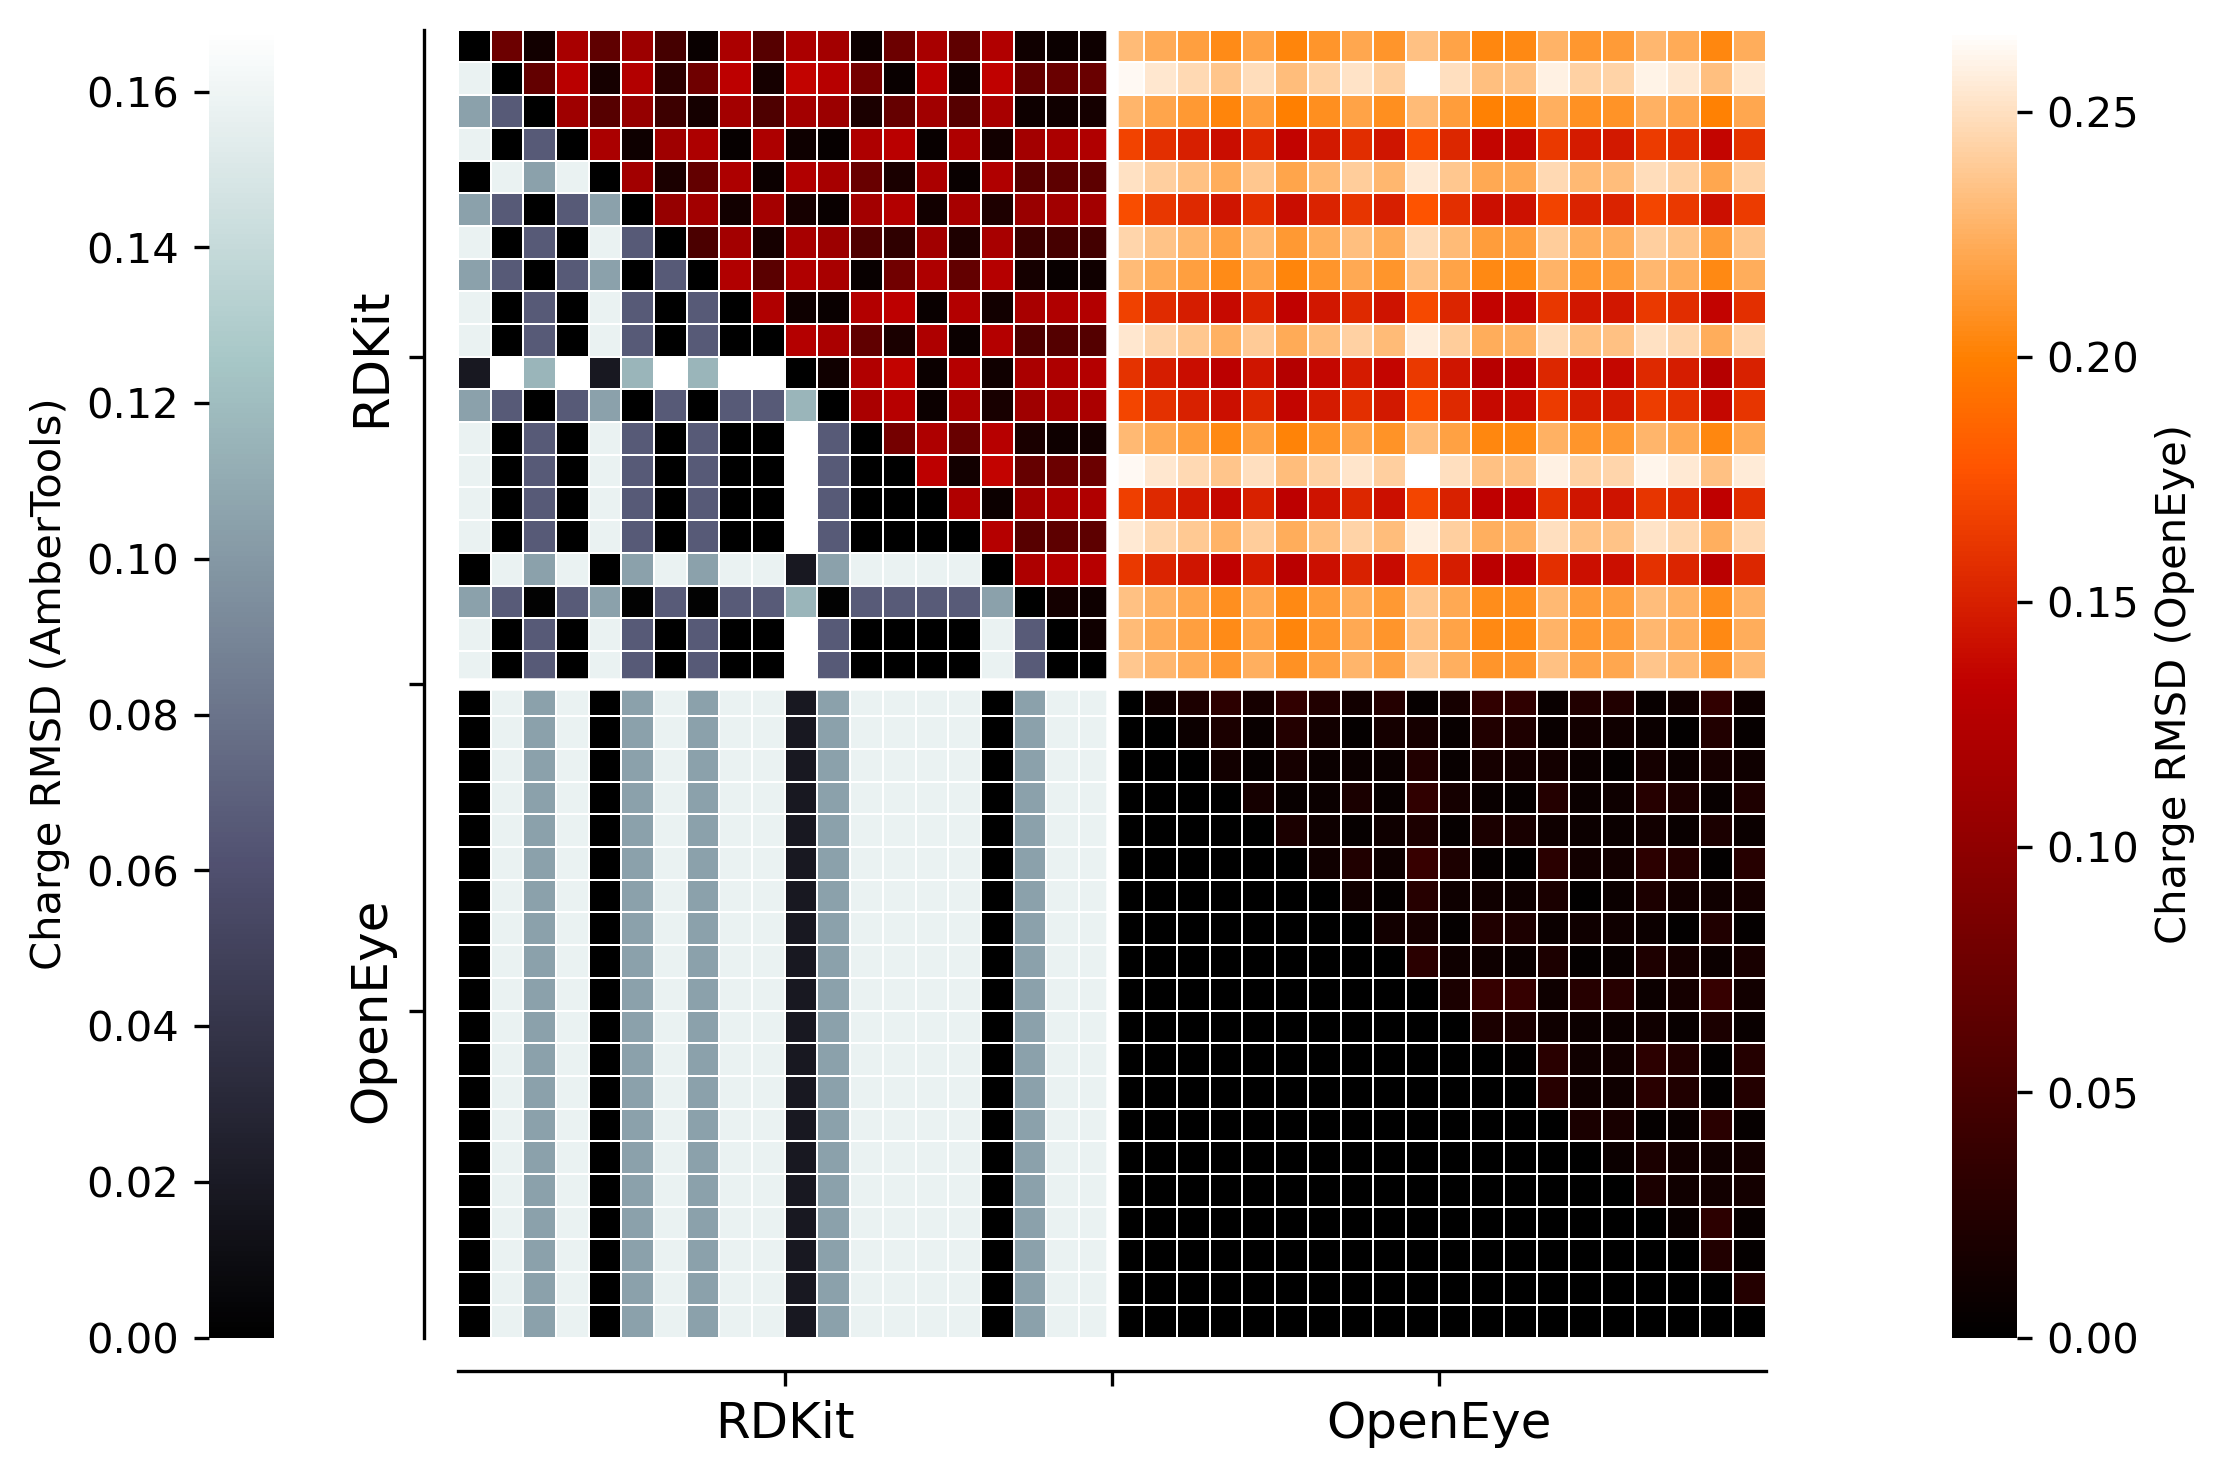

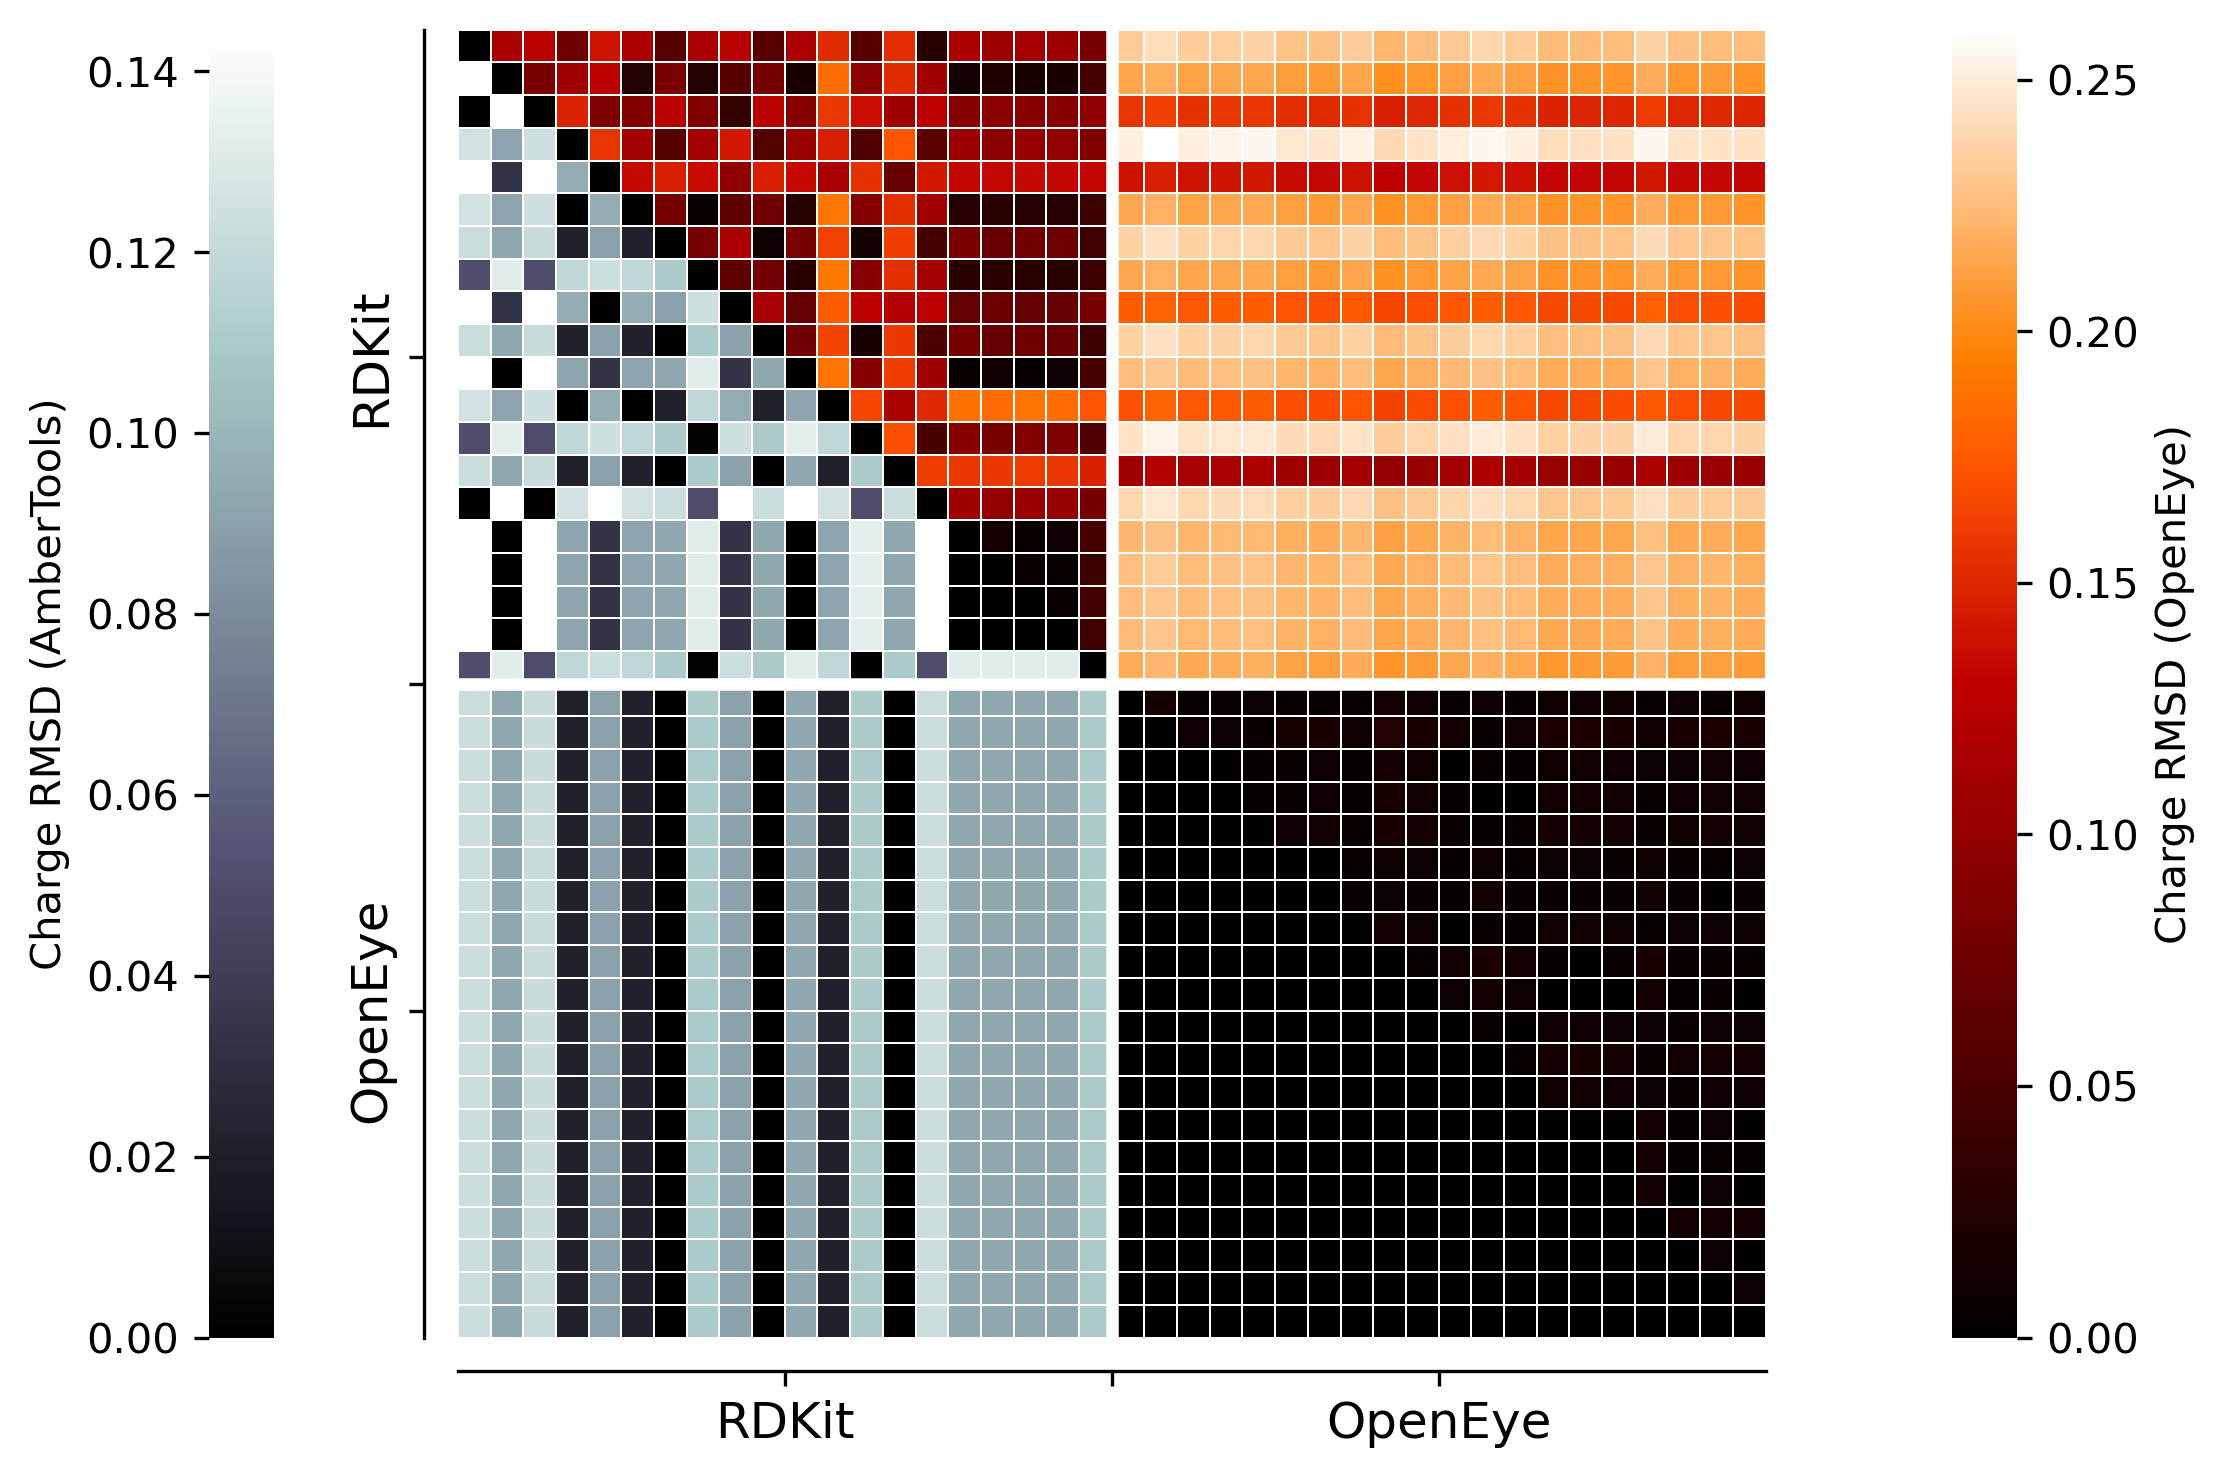

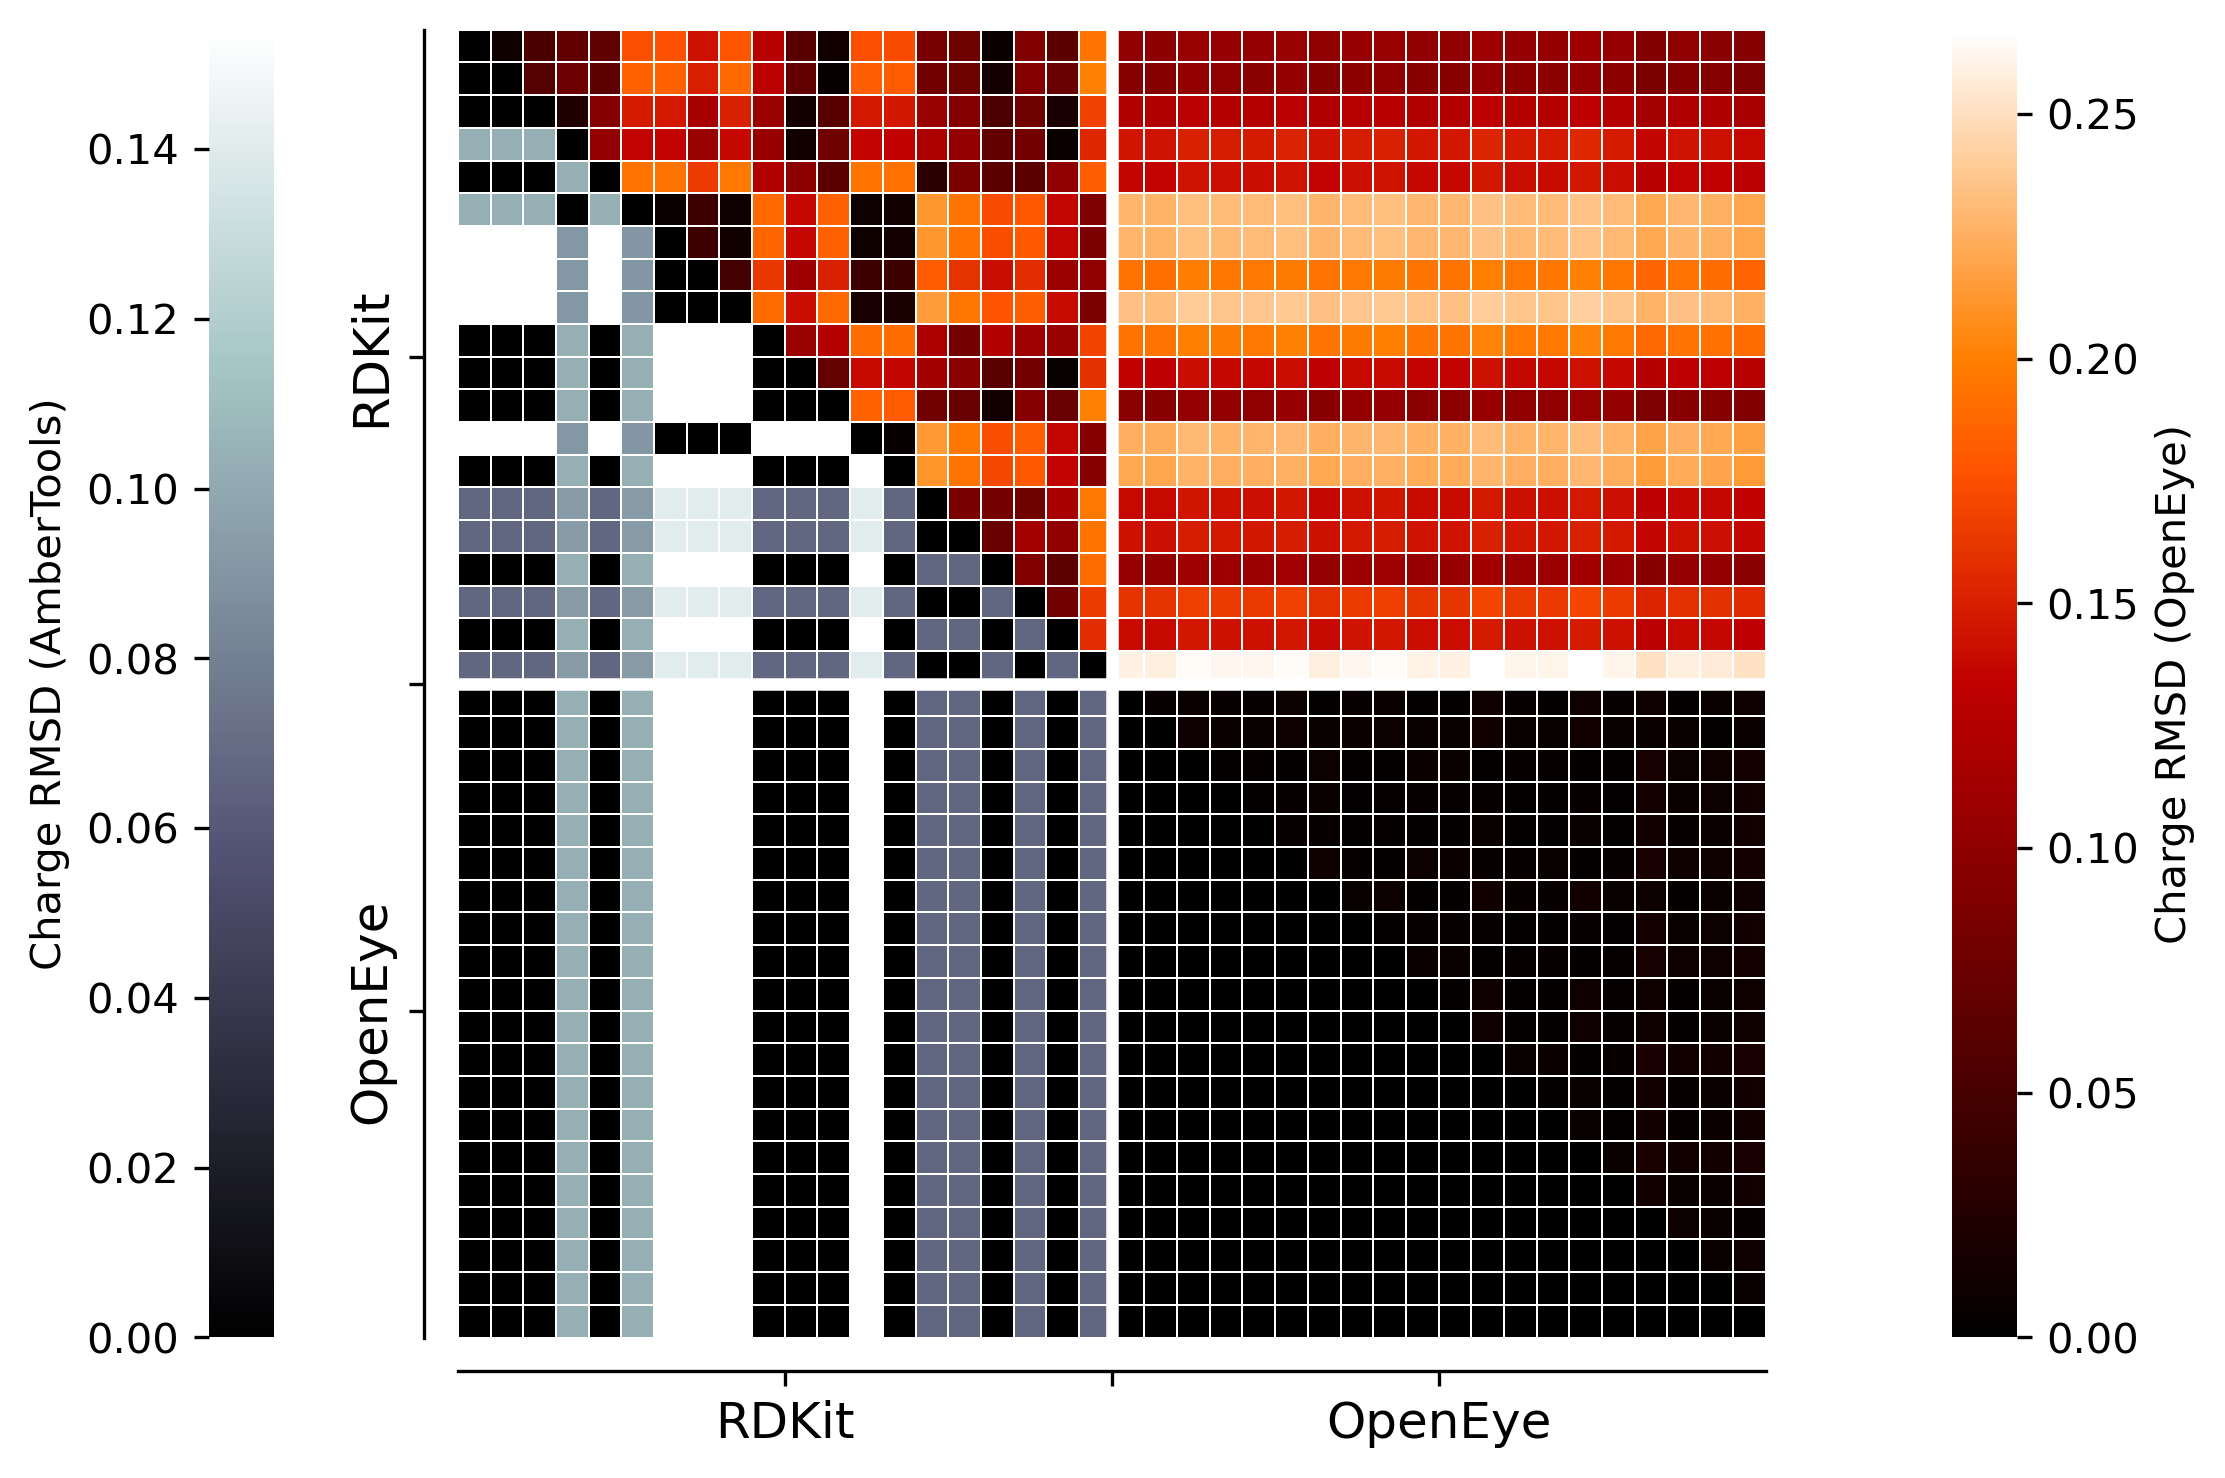

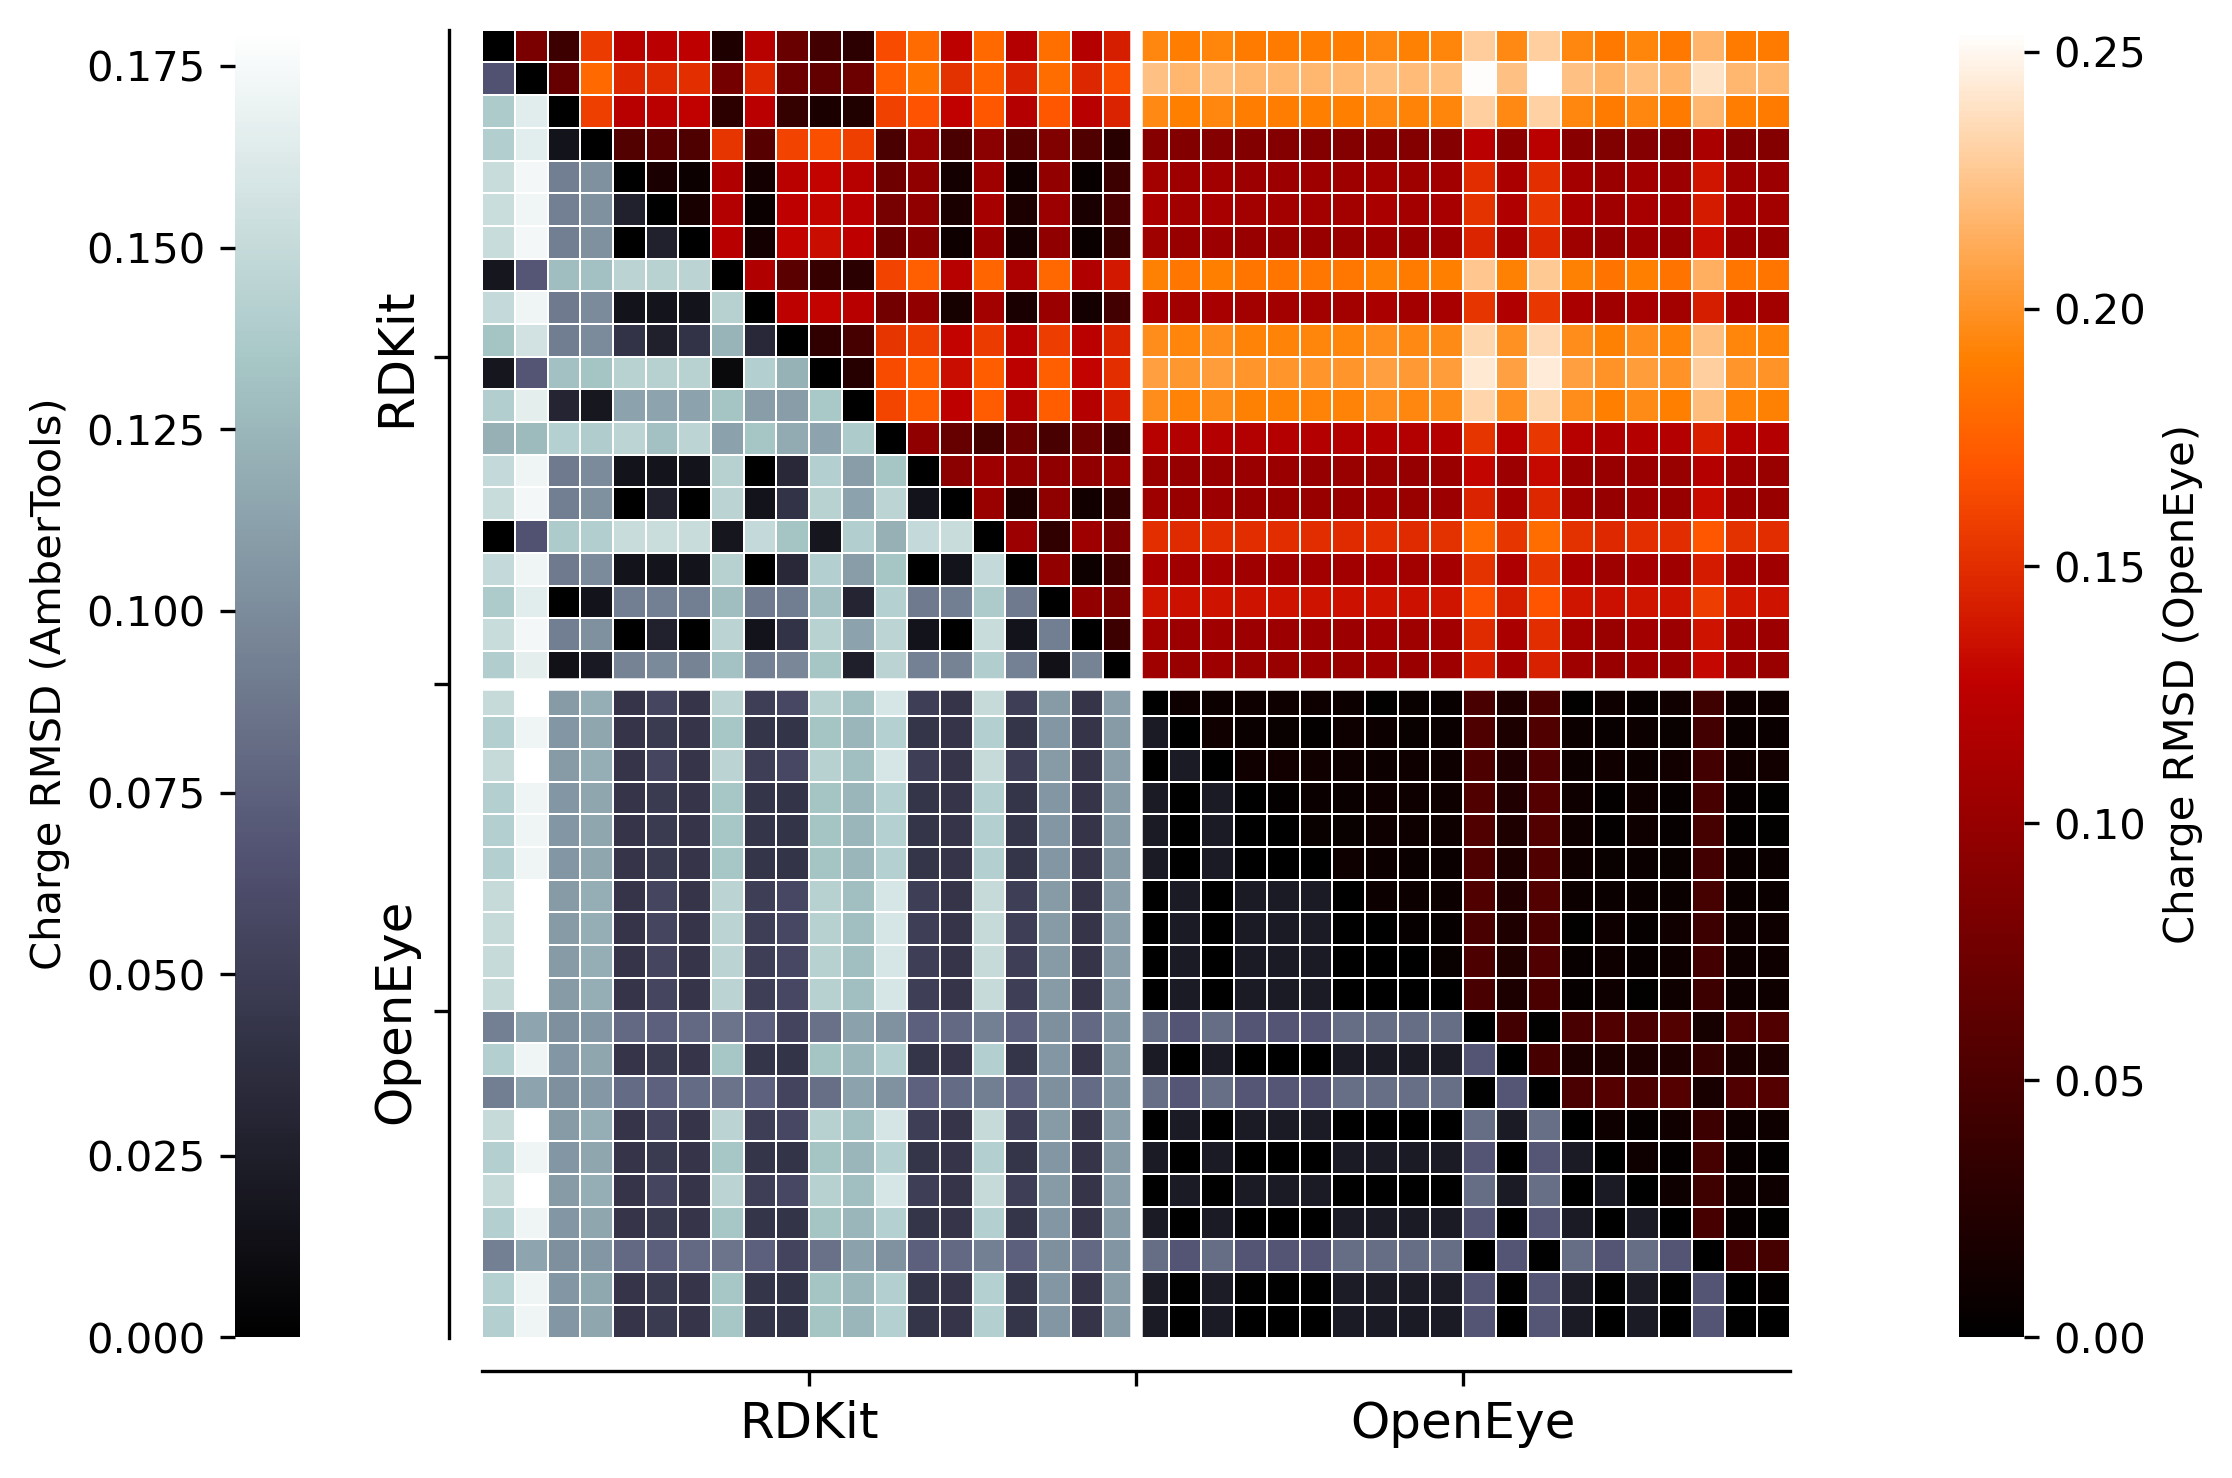

In [44]:
for i in range(90, 100):
#     try:
        plot_oe_vs_at_rmsd(i+1)
#     except:
#         pass

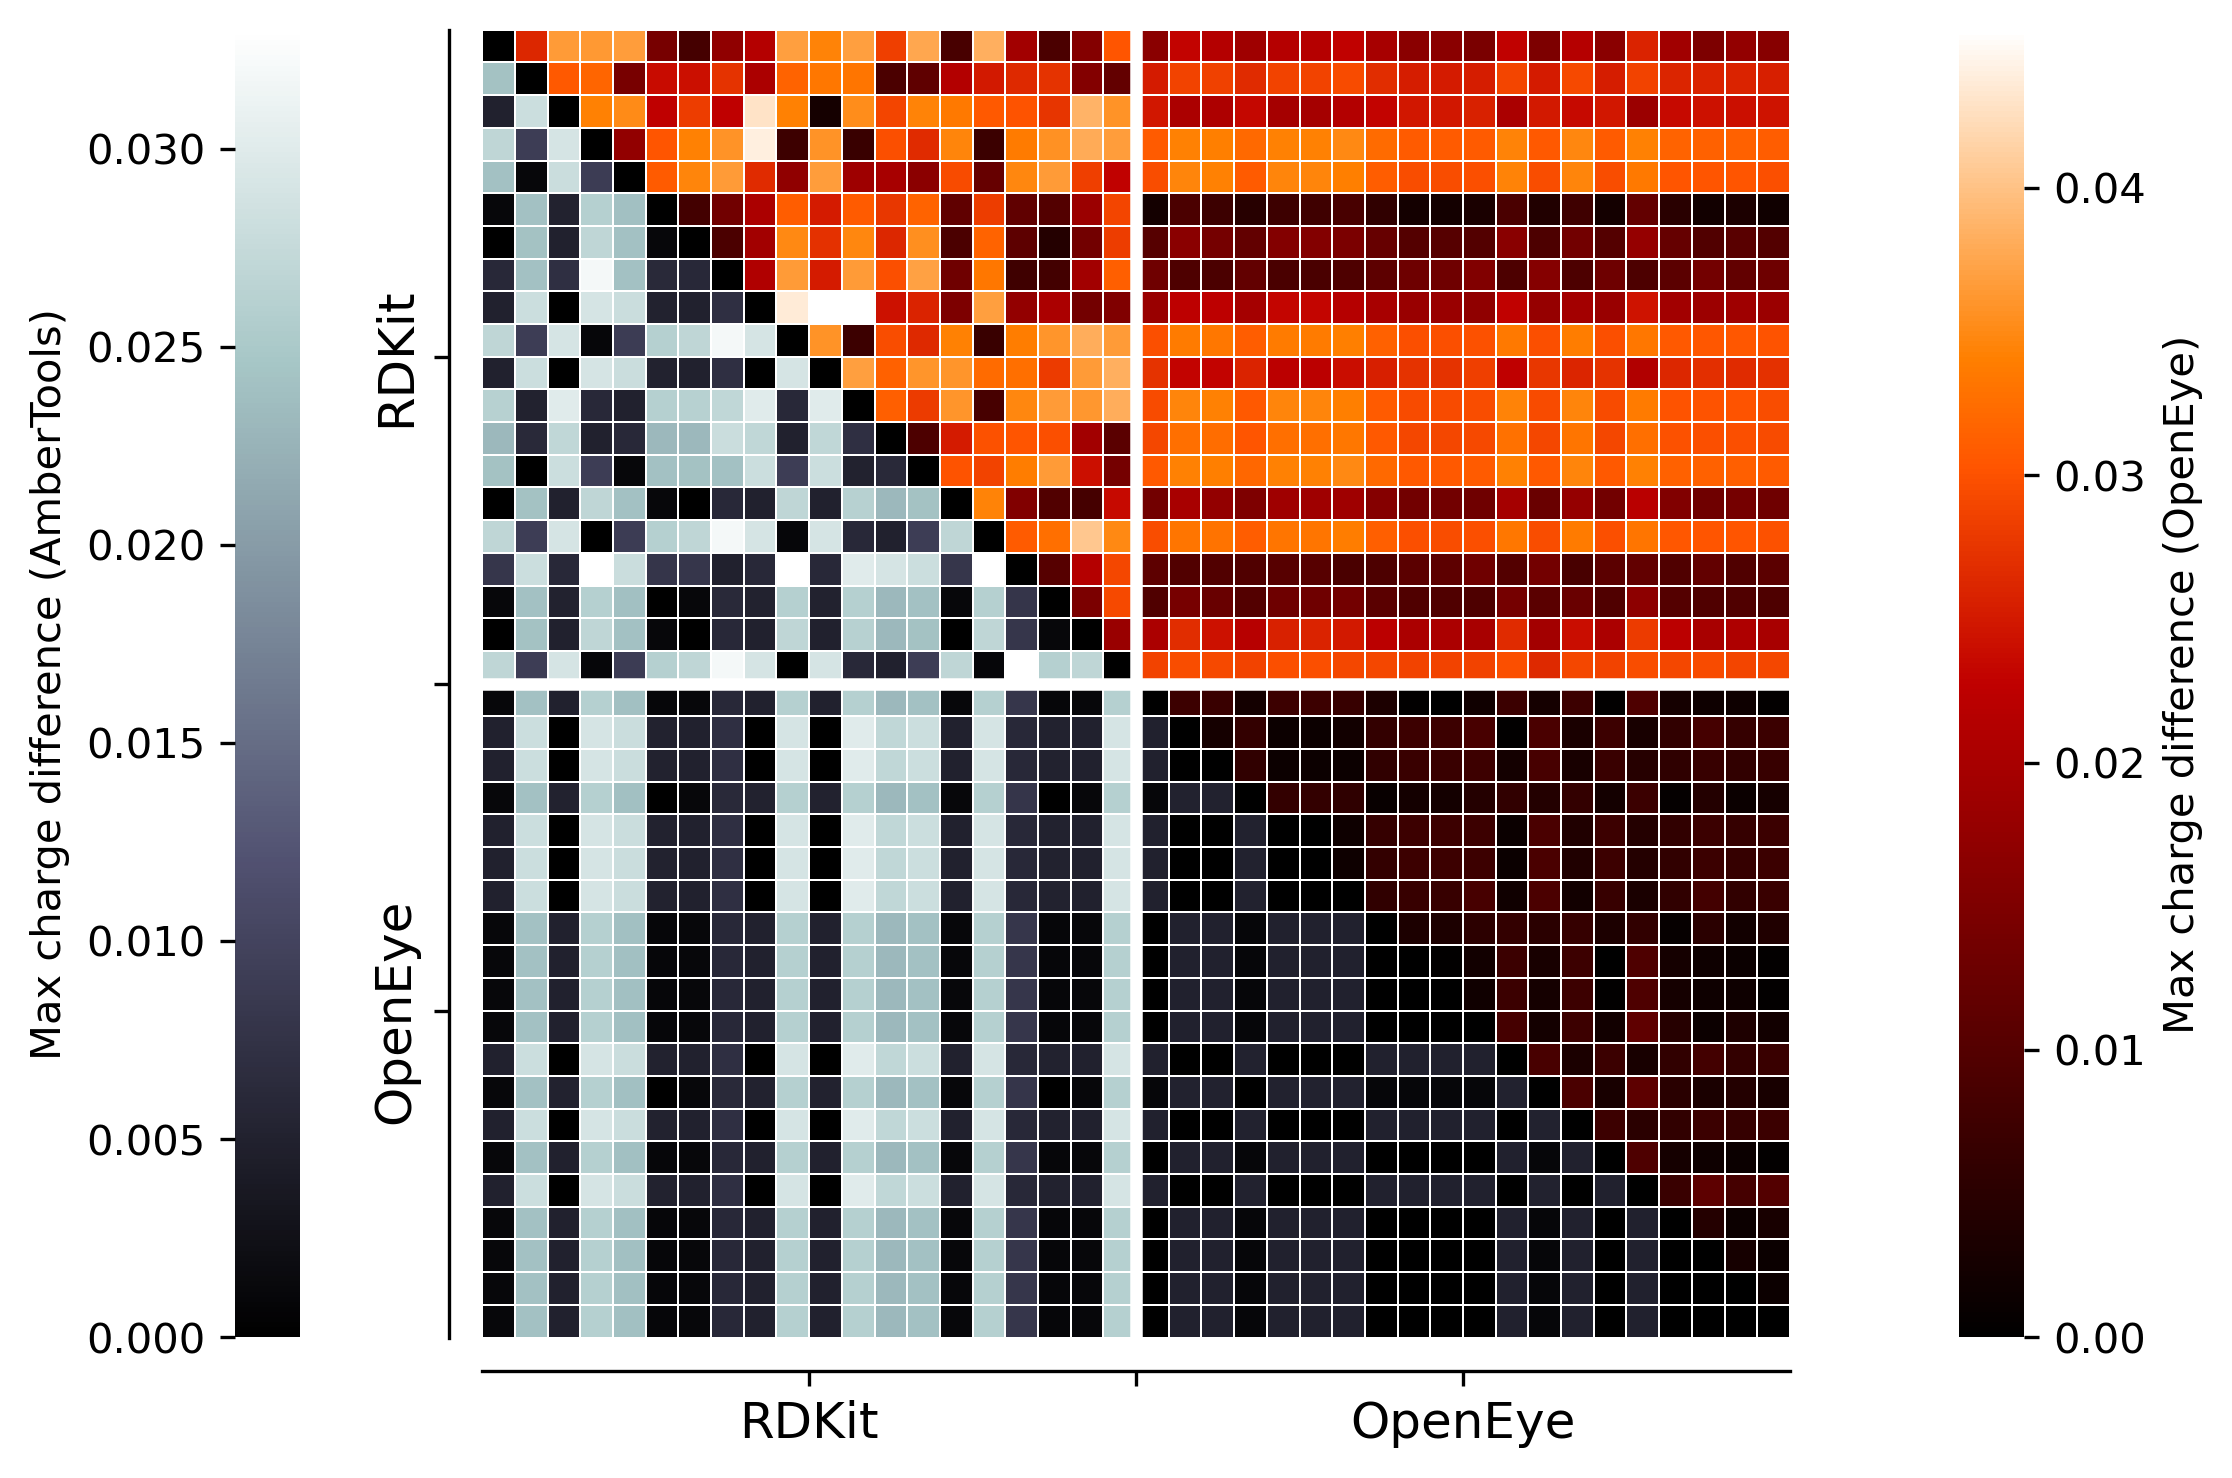

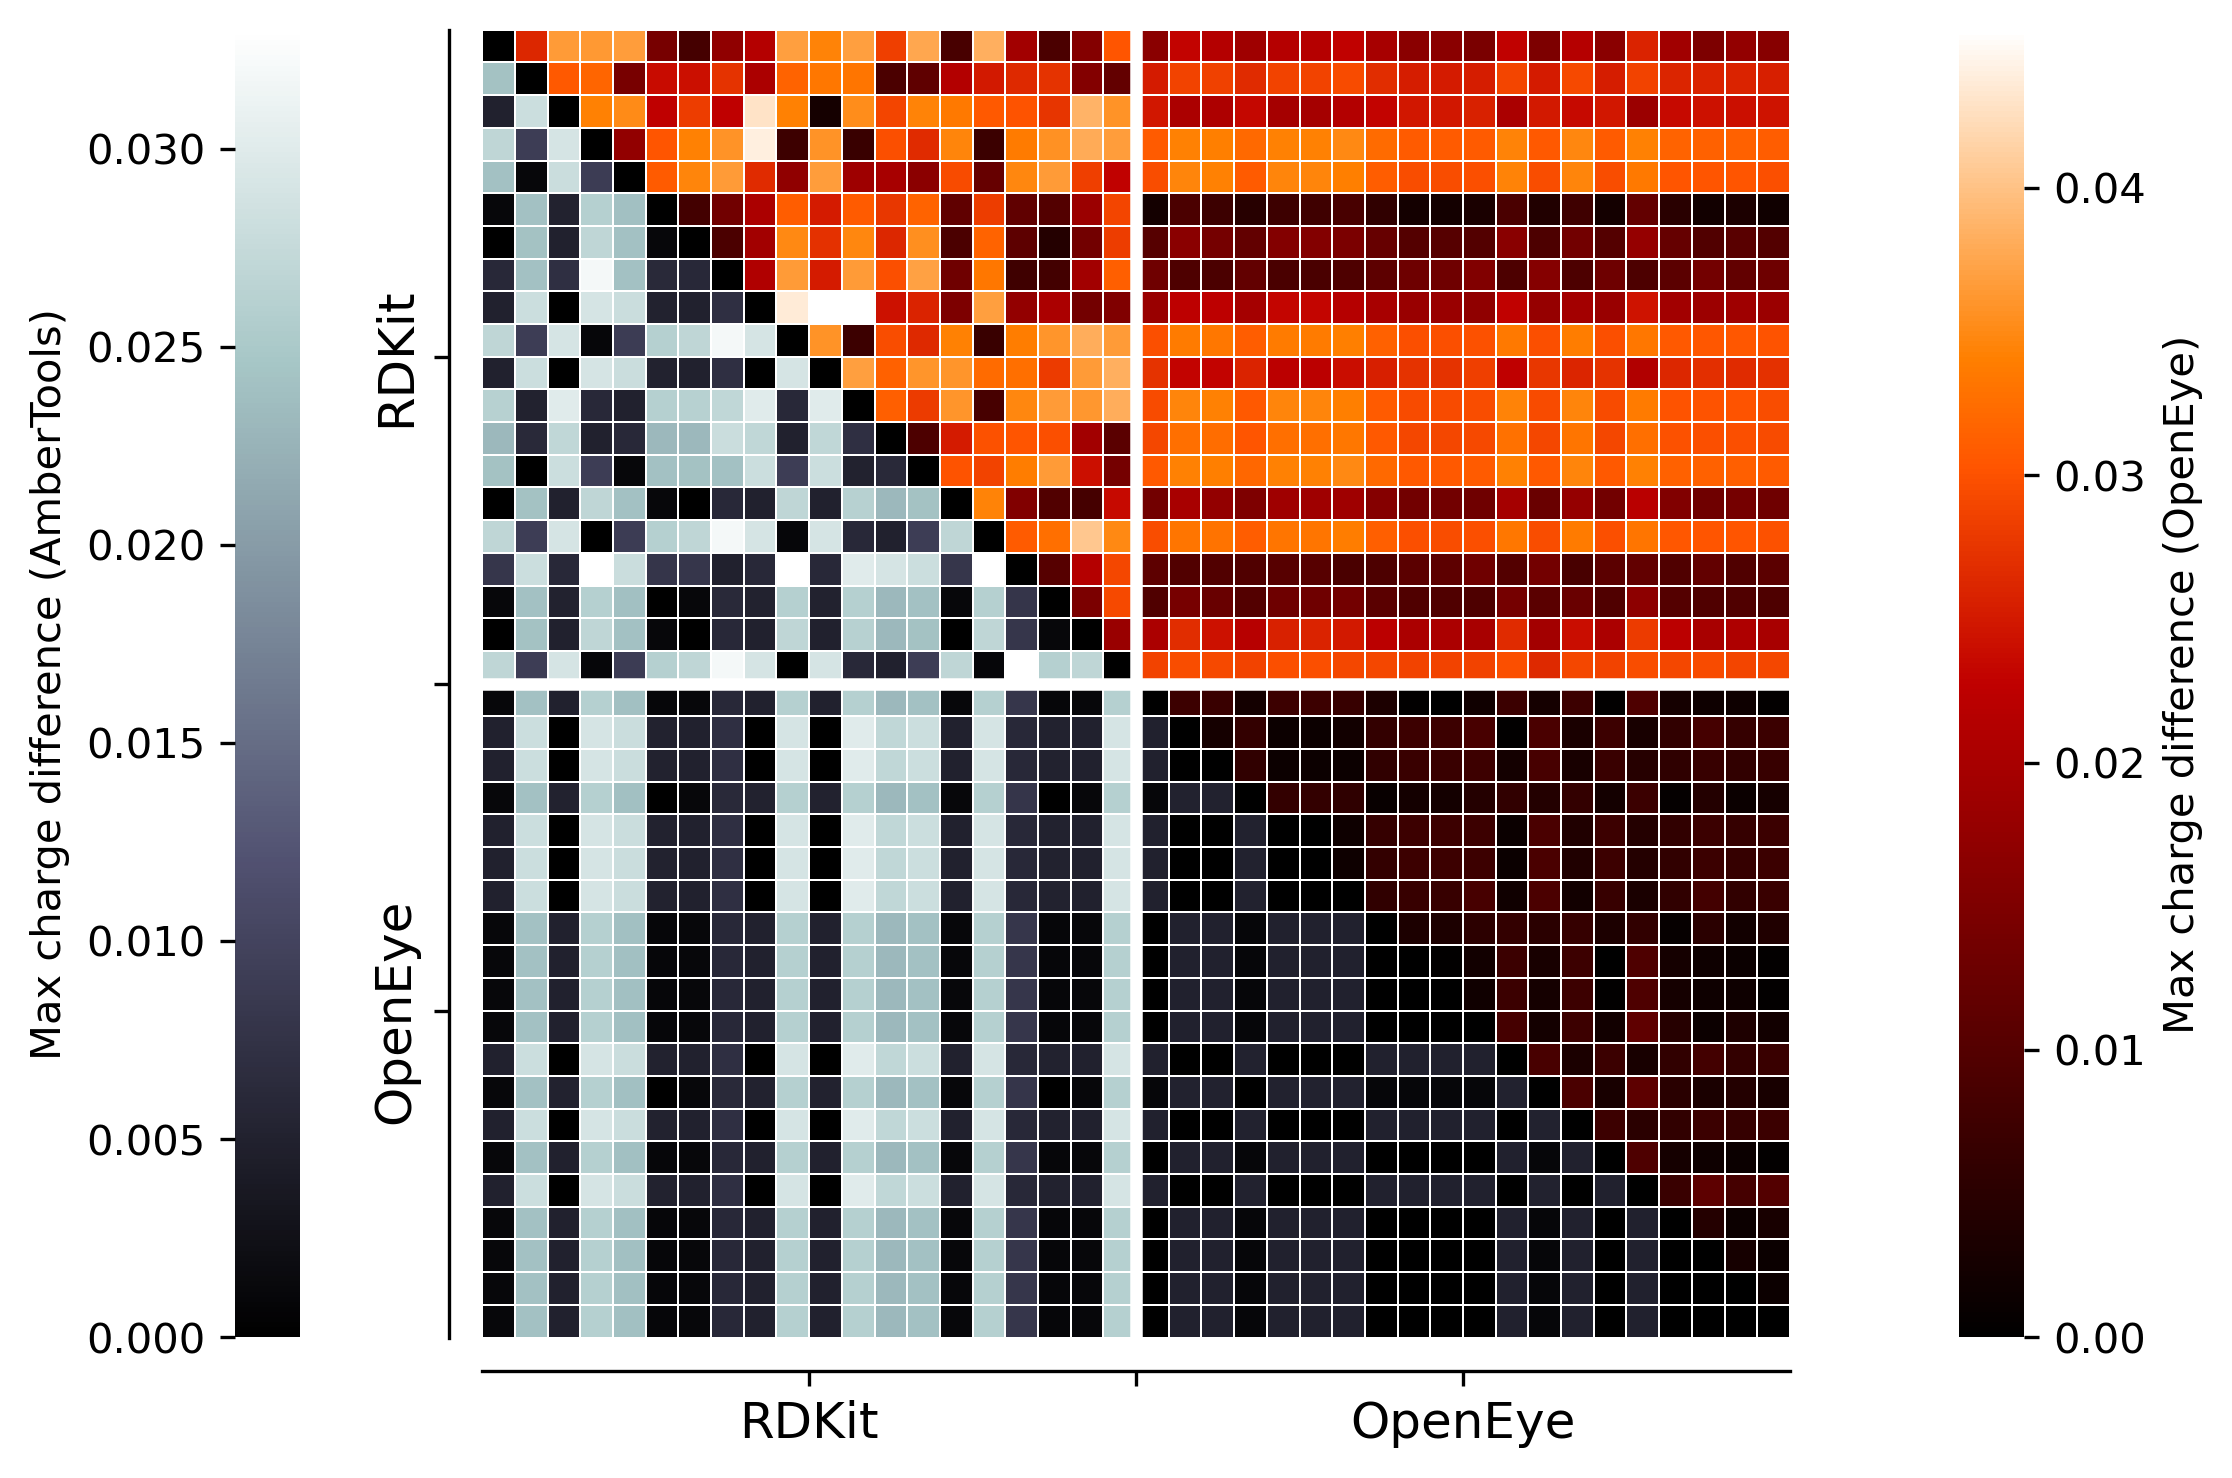

In [64]:
plot_oe_vs_at_max()

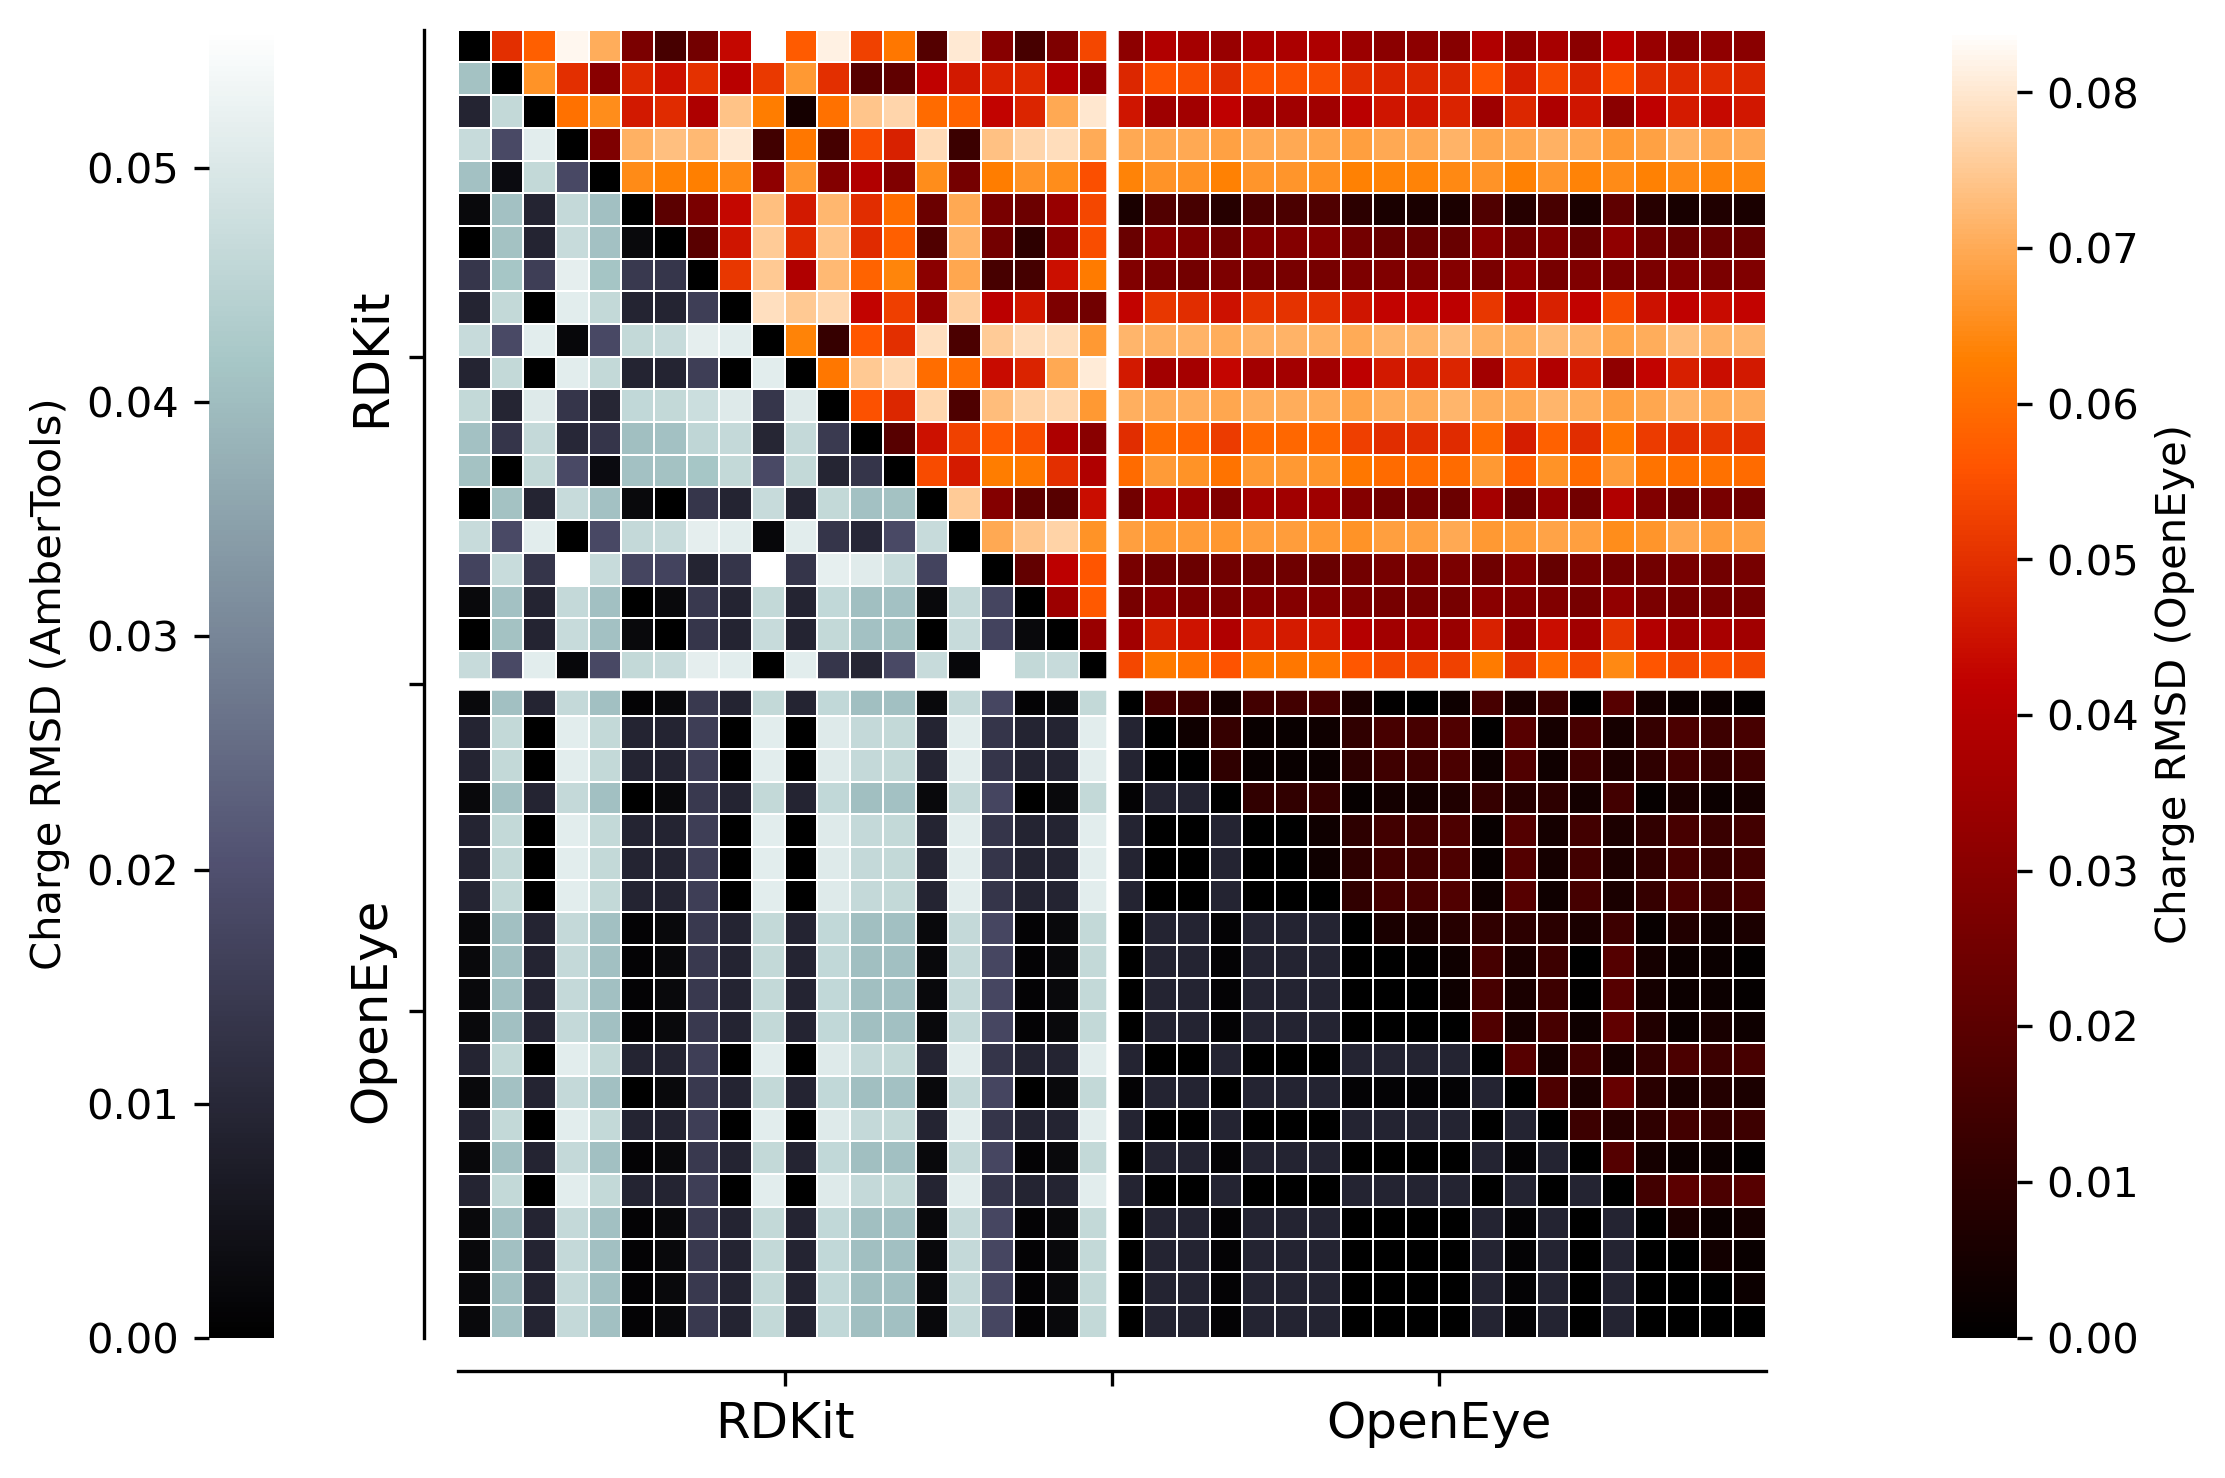

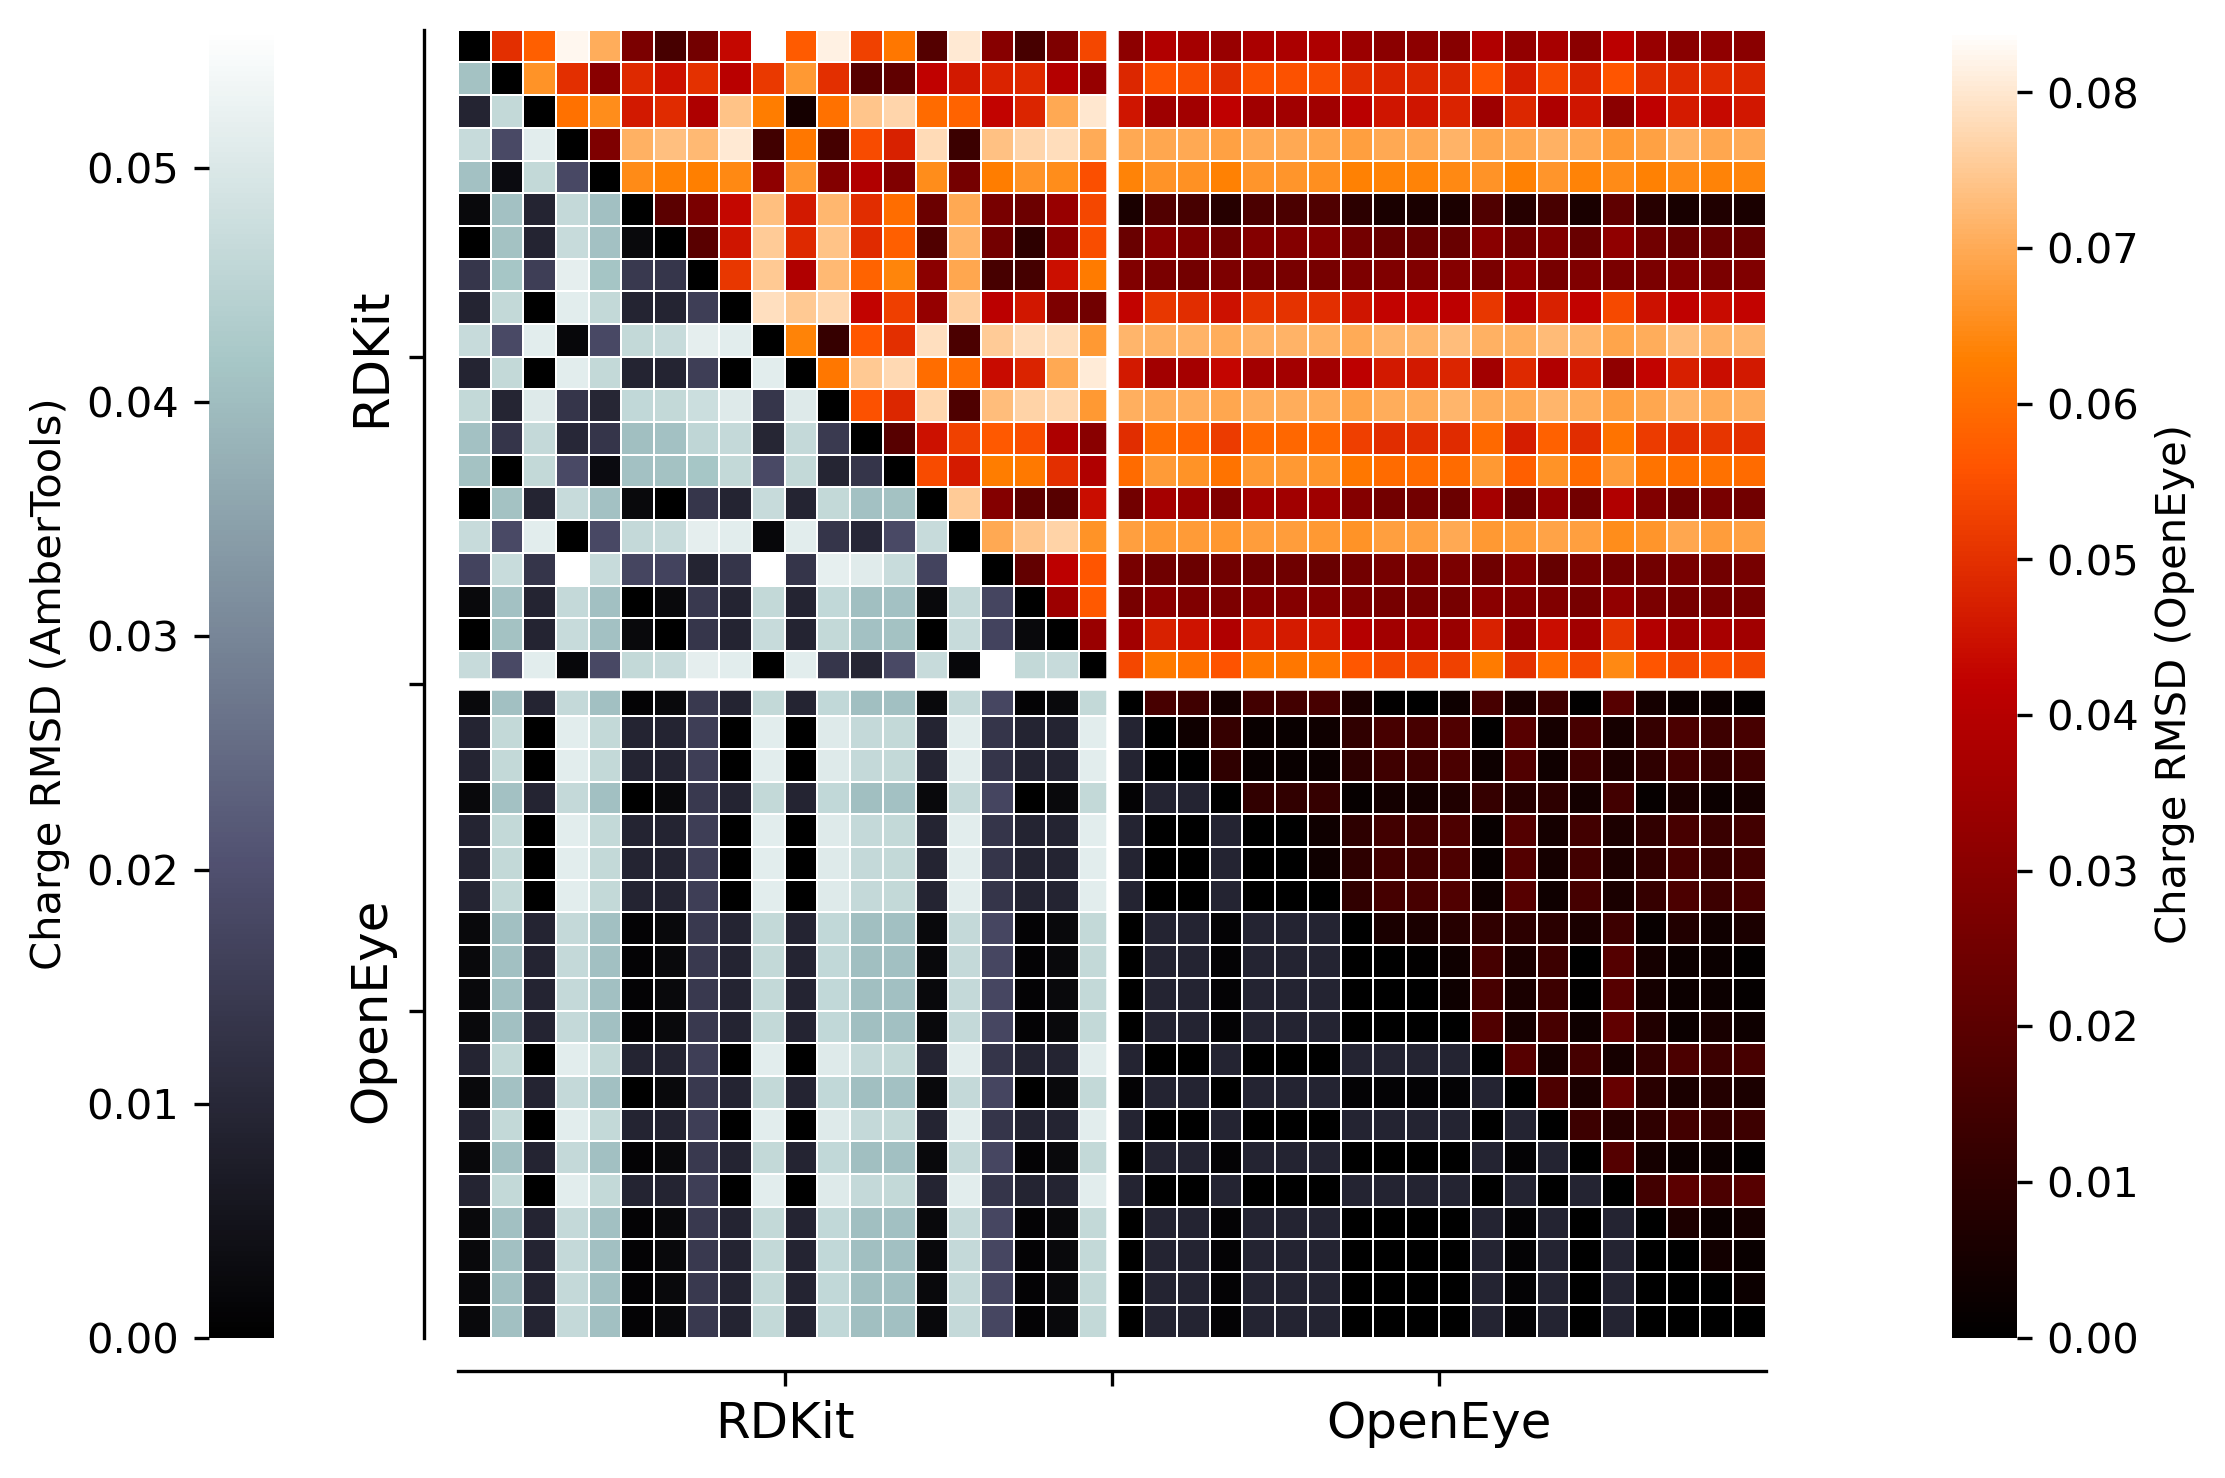

In [60]:
plot_oe_vs_at_rmsd()

In [2]:
with open("../openff_parsley_benchmark.smi", "r") as f:
    smiles = [x.strip() for x in f.readlines()]

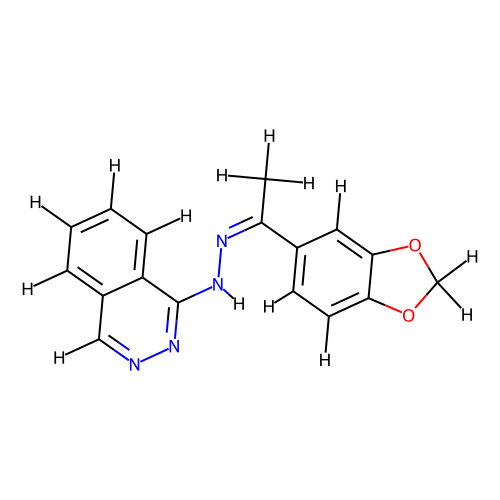

In [28]:
Molecule.from_smiles(smiles[94]).visualize(backend="rdkit")

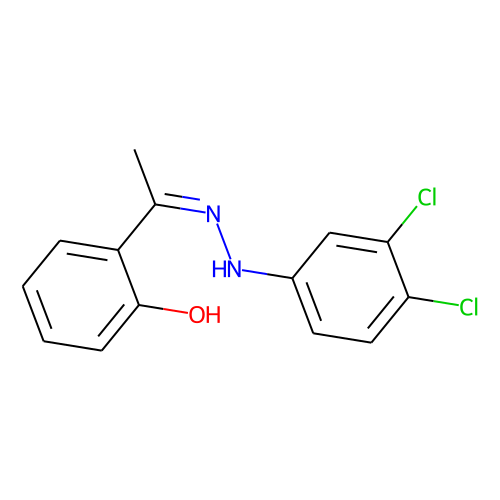

In [27]:
from rdkit import Chem
Chem.MolFromSmiles(smiles[95])

In [50]:
from collections import defaultdict

chgdct = defaultdict(list)

for i in range(4066):
    files = sorted(glob.glob(f"charges/mol{i+1:04d}*"), reverse=True)
    if not len(files) == 8:
        continue
    for file in files:
        conformers, toolkit, method = file.split("_")[1:]
        conformers = conformers[:2]
        method = method.split(".")[0]
        chgdct[(conformers, toolkit, method)].append(np.load(file))
        
    
    

In [62]:
dfdct = {"Conformer toolkit difference": [], "Charge toolkit difference": [], "Charge model": []}

for cm in ["am1", "elf10"]:
    for x, y in zip(chgdct[("rd", "at", cm)], chgdct[("rd", "oe", cm)]):
        v = ((x - y) ** 2).mean() ** 0.5
        dfdct["Charge toolkit difference"].append(v)
        dfdct["Charge model"].append(cm)
        
    for x, y in zip(chgdct[("oe", "at", cm)], chgdct[("oe", "oe", cm)]):
        v = ((x - y) ** 2).mean() ** 0.5
        dfdct["Charge toolkit difference"].append(v)
        dfdct["Charge model"].append(cm)
        
    for x, y in zip(chgdct[("rd", "at", cm)], chgdct[("oe", "at", cm)]):
        v = ((x - y) ** 2).mean() ** 0.5
        dfdct["Conformer toolkit difference"].append(v)
#         dfdct["Charge model"].append(cm)
        
    for x, y in zip(chgdct[("rd", "oe", cm)], chgdct[("oe", "oe", cm)]):
        v = ((x - y) ** 2).mean() ** 0.5
        dfdct["Conformer toolkit difference"].append(v)
#         dfdct["Charge model"].append(cm)
    

/var/folders/rv/j6lbln6j0kvb5svxj8wflc400000gn/T/ipykernel_1672/2115694218.py:5: RuntimeWarning: Mean of empty slice.
  v = ((x - y) ** 2).mean() ** 0.5
/var/folders/rv/j6lbln6j0kvb5svxj8wflc400000gn/T/ipykernel_1672/2115694218.py:10: RuntimeWarning: Mean of empty slice.
  v = ((x - y) ** 2).mean() ** 0.5
/var/folders/rv/j6lbln6j0kvb5svxj8wflc400000gn/T/ipykernel_1672/2115694218.py:15: RuntimeWarning: Mean of empty slice.
  v = ((x - y) ** 2).mean() ** 0.5
/var/folders/rv/j6lbln6j0kvb5svxj8wflc400000gn/T/ipykernel_1672/2115694218.py:20: RuntimeWarning: Mean of empty slice.
  v = ((x - y) ** 2).mean() ** 0.5


In [63]:
for k, v in dfdct.items():
    print(k, len(v))

Conformer toolkit difference 740
Charge toolkit difference 740
Charge model 740


In [64]:
import pandas as pd

df = pd.DataFrame(dfdct)

In [67]:
df[df["Charge model"] == "elf10"]

,Conformer toolkit difference,Charge toolkit difference,Charge model
370,0.005993,0.007442,elf10
371,0.010433,0.008479,elf10
372,0.002325,0.007477,elf10
373,0.008487,0.008893,elf10
374,0.010705,0.009014,elf10
...,...,...,...
735,NaN,NaN,elf10
736,NaN,NaN,elf10
737,NaN,NaN,elf10
738,NaN,NaN,elf10


(array([272., 163.,  64.,  20.,   6.,  10.,  11.,   8.,   9.,   5.]),
 array([0.0001609 , 0.01236371, 0.02456653, 0.03676934, 0.04897215,
        0.06117497, 0.07337778, 0.08558059, 0.09778341, 0.10998622,
        0.12218903]),
 <BarContainer object of 10 artists>)

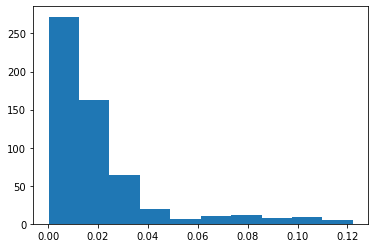

In [69]:
from matplotlib import pyplot as plt

plt.hist(df["Charge toolkit difference"])

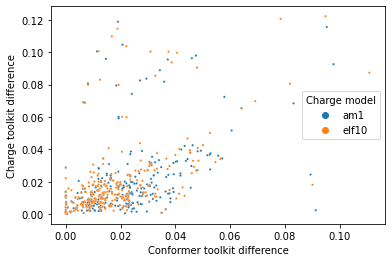

In [78]:
import seaborn as sns

# g = sns.FacetGrid(data=df, col="Charge model")
# g.map(sns.kdeplot, "Conformer toolkit difference", "Charge toolkit difference")

sns.scatterplot(data=df, x="Conformer toolkit difference",
            y="Charge toolkit difference", #bw_adjust=0.2,
            hue="Charge model", s=5)
plt.savefig("toolkit_differences2.png", dpi=300)